## Задача: проверить различные преобразования и аугментации данных и посмотреть как будет меняться качество

В качестве модели будем использовать ахитектуру VGG.

[Very Deep Convolutional Networks for Large-Scale Image Recognition](https://arxiv.org/abs/1409.1556)

In [36]:
# Подключаем необходимые библиотеки
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torchsummary import summary
from torchvision.transforms.v2 import ToDtype, ToTensor
from torchviz import make_dot
from torchvision import models
from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau
from PIL import Image 

import matplotlib.pyplot as plt
import os
import pandas as pd

In [37]:
# Определяем гиперпараметры

batch_size = 32
num_epochs = 75
lr = 0.001
device = "cpu"

# Для transform

size = (64, 64)


if torch.cuda.is_available():
    device = torch.cuda

# cuda0 = torch.device('cuda')

print(device)
# print(cuda0)

cpu


In [38]:
# Путь к данным

data_dir = "./human_poses_data"
train_dir = os.path.join(data_dir, "img_train")
test_dir = os.path.join(data_dir, "img_test")
train_labels_path = os.path.join(data_dir, "train_answers.csv")

global_img_train_path = './human_poses_data'

# Чтение файла с метками
train_labels = pd.read_csv(train_labels_path)

print(data_dir)
train_labels['target_feature'].max()


./human_poses_data


18

In [39]:
train_labels

,img_id,target_feature
0,17363,2
1,8612,5
2,8244,0
3,9264,0
4,5382,6
...,...,...
12362,11503,4
12363,12201,6
12364,5489,3
12365,883,5


Добавим новые функции для сохранения чекпоинтов и модели.

[Saving and Loading Models](https://pytorch.org/tutorials/beginner/saving_loading_models.html)

In [40]:
# Добавляем новые функции для сохранения чекпоинтов

def save_checkpoint(model, optimizer, epoch, loss, filename="checkpoint.pth"):
    """Сохраняет чекпоинт модели и оптимизатора."""
    checkpoint = {
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "epoch": epoch,
        "loss": loss,
    }
    torch.save(checkpoint, filename)
    print(f"Checkpoint saved: {filename}, epoch {epoch}, loss {loss:.4f}")

def load_checkpoint(model, optimizer, filename="checkpoint.pth"):
    """Загружает чекпоинт модели и оптимизатора."""
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    epoch = checkpoint["epoch"]
    loss = checkpoint["loss"]
    print(f"Checkpoint loaded: {filename}, epoch {epoch}, loss {loss:.4f}")
    return epoch, loss

In [41]:
# Произведем пребразования над данными для последующей их передачи в модель

# transform_train = transforms.Compose([
#     transforms.Resize(size=size), # Уменьшаем и приводим изображения к одному размеру
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
# ])

# transform_test = transforms.Compose([
#     transforms.Resize(size=size), # Уменьшаем и приводим изображения к одному размеру
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
# ])

# transform = transforms.Compose([
#     transforms.Resize(size=size),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation(15),
#     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
#     transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
#     transforms.ToTensor(),
#     ToDtype(torch.float32, scale=True),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
# ])

train_transform = transforms.Compose([
    transforms.Resize(size=size), 
    transforms.RandomRotation(5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomApply([transforms.RandomAffine(degrees=2, translate=(0.1, 0.1))]),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=1, sigma=(0.1, 2)), transforms.RandomGrayscale()]),
    transforms.RandomHorizontalFlip(),
    transforms.RandomChoice([transforms.RandomAdjustSharpness(1), transforms.RandAugment()]),
    transforms.ToTensor(),
    ToDtype(torch.float32, scale=True),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_transform_for_visualize = transforms.Compose([
    transforms.Resize(size=size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_val_transform = transforms.Compose([
    transforms.Resize(size=size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [116]:
# Пайплайн 1
train_transform_1 = transforms.Compose([
    transforms.Resize(size=size), 
    transforms.RandomRotation(degrees=3),  # Немного больше вращения
    transforms.ColorJitter(brightness=0.5, saturation=0.3),  # Контроль цвета и контраста
    transforms.RandomHorizontalFlip(p=0.5),  # Случайный горизонтальный флип
    transforms.RandomAdjustSharpness(sharpness_factor=0.8),  # Усиление резкости
    transforms.ToTensor(),
    ToDtype(torch.float32, scale=True),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Пайплайн 2
train_transform_2 = transforms.Compose([
    transforms.Resize(size=size),
    transforms.RandomApply([transforms.RandomPerspective(distortion_scale=0.5, p=0.5)]),  # Перспективные искажения
    transforms.ColorJitter(brightness=0.6, saturation=0.4),  # Более мягкие цветовые изменения
    transforms.RandomApply([transforms.RandomAffine(degrees=10, shear=5)]),  # Легкий сдвиг
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    ToDtype(torch.float32, scale=True),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Пайплайн 3
train_transform_3 = transforms.Compose([
    transforms.Resize(size=size),
    transforms.RandomAffine(degrees=2, translate=(0.1, 0.1), scale=(0.9, 1.1)),  # Легкие афинные преобразования
    transforms.ColorJitter(hue=0.2, saturation=0.4),  # Мягкие изменения цвета
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=1, sigma=(0.1, 2))], p=0.5),  # Легкое размытие
    transforms.RandomAdjustSharpness(sharpness_factor=1.1, p=0.3),  # Лёгкая корректировка резкости
    transforms.ToTensor(),
    ToDtype(torch.float32, scale=True),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Эти пайплайны похожи на первый пайплайн, эксперементируем с ним

# train_transform = transforms.Compose([
#     transforms.Resize(size=size), 
#     transforms.RandomRotation(5),
#     transforms.ColorJitter(brightness=1.5, saturation=0.2),
#     transforms.RandomApply([transforms.RandomAffine(degrees=2, translate=(0.1, 0.1))]),
#     transforms.RandomApply([transforms.GaussianBlur(kernel_size=1, sigma=(0.1, 2)), transforms.RandomGrayscale()]),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomChoice([transforms.RandomAdjustSharpness(1), transforms.RandAugment()]),
#     transforms.ToTensor(),
#     ToDtype(torch.float32, scale=True),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
# ])

# Пайплайн 4
train_transform_4 = transforms.Compose([
    transforms.Resize(size=size),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=3),
    transforms.ColorJitter(brightness=0.8, contrast=0.4, saturation=0.5, hue=0.2),
    transforms.RandomAffine(degrees=10, scale=(0.8, 1.2), shear=5),
    transforms.RandomPerspective(distortion_scale=0.4, p=0.5),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=1, sigma=(0.1, 2))], p=0.3),
    transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor(),
    ToDtype(torch.float32, scale=True),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


# Пайплайн 5
train_transform_5 = transforms.Compose([
    transforms.Resize(size=size),
    transforms.RandomAffine(degrees=2, scale=(0.8, 1.2), shear=5),
    transforms.RandomApply([transforms.RandomRotation(30)], p=0.4),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomApply([transforms.ColorJitter(brightness=0.7, contrast=0.7)], p=0.3),
    transforms.RandomChoice([
        transforms.GaussianBlur(kernel_size=1, sigma=(0.1, 1)),
        transforms.RandomAdjustSharpness(sharpness_factor=2.0, p=0.5)
    ]),
    transforms.ToTensor(),
    ToDtype(torch.float32, scale=True),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Пайплайн 6
train_transform_6 = transforms.Compose([
    transforms.Resize(size=size),
    transforms.RandomRotation(degrees=3),
    transforms.RandomHorizontalFlip(),
    transforms.RandomApply([
        transforms.RandomAffine(degrees=4, translate=(0.2, 0.2)),
        transforms.RandomPerspective(distortion_scale=0.3)
    ], p=0.4),
    transforms.RandomGrayscale(p=0.2),
    transforms.ColorJitter(brightness=0.9, saturation=0.3, hue=0.2),
    transforms.RandomChoice([
        transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1)),
        transforms.RandomAdjustSharpness(sharpness_factor=1.2, p=0.5)
    ]),
    transforms.ToTensor(),
    ToDtype(torch.float32, scale=True),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [100]:
# Определим удобный класс Dataset для хранения данных

class HumanPoseDataset(Dataset):
    def __init__(self, img_dir, labels_df=None, transform=None):
        self.img_dir = img_dir
        self.labels_df = labels_df
        self.transform = transform
        self.img_files = os.listdir(self.img_dir)

    def __len__(self):
        return len(self.labels_df) if self.labels_df is not None else len(os.listdir(self.img_dir))
    
    def __getitem__(self, index):
        img_name = self.img_files[index]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        if self.labels_df is not None:
            img_id = int(os.path.splitext(img_name)[0])
            matching_rows = self.labels_df.loc[self.labels_df['img_id'] == img_id, "target_feature"]
            if not matching_rows.empty:
                label = matching_rows.values[0]
                return image, label
            
        else:
            return image, img_name


In [117]:
# Создаем DataLoader

train_dataset = HumanPoseDataset(train_dir, labels_df=train_labels, transform=train_transform)
train_dataset_view = HumanPoseDataset(train_dir, labels_df=train_labels, transform=train_transform_for_visualize)
test_dataset = HumanPoseDataset(test_dir, transform=test_val_transform)

# Проверяем разные аугментации
train_dataset_pipeline1 = HumanPoseDataset(train_dir, labels_df=train_labels, transform=train_transform_1)
train_dataset_pipeline2 = HumanPoseDataset(train_dir, labels_df=train_labels, transform=train_transform_2)
train_dataset_pipeline3 = HumanPoseDataset(train_dir, labels_df=train_labels, transform=train_transform_3)
train_dataset_pipeline4 = HumanPoseDataset(train_dir, labels_df=train_labels, transform=train_transform_4)
train_dataset_pipeline5 = HumanPoseDataset(train_dir, labels_df=train_labels, transform=train_transform_5)
train_dataset_pipeline6 = HumanPoseDataset(train_dir, labels_df=train_labels, transform=train_transform_6)

# Разделяем обучающий датасет на валидационную и обучающую выборки
val_size = int(0.2 * len(train_dataset))
train_size = len(train_dataset) - val_size
train_data, val_data = random_split(train_dataset, [train_size, val_size])

# выборки из разных пайплайнов
train_data1, val_data1 = random_split(train_dataset_pipeline1, [train_size, val_size])
train_data2, val_data2 = random_split(train_dataset_pipeline2, [train_size, val_size])
train_data3, val_data3 = random_split(train_dataset_pipeline3, [train_size, val_size])
train_data4, val_data4 = random_split(train_dataset_pipeline4, [train_size, val_size])
train_data5, val_data5 = random_split(train_dataset_pipeline5, [train_size, val_size])
train_data6, val_data6 = random_split(train_dataset_pipeline6, [train_size, val_size])

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Loader для 1 пайплайна
train_loader1 = DataLoader(train_data1, batch_size=batch_size, shuffle=True)
val_loader1 = DataLoader(val_data1, batch_size=batch_size, shuffle=False)

# Loader для 2 пайплайна
train_loader2 = DataLoader(train_data2, batch_size=batch_size, shuffle=True)
val_loader2 = DataLoader(val_data2, batch_size=batch_size, shuffle=False)

# Loader для 3 пайплайна
train_loader3 = DataLoader(train_data3, batch_size=batch_size, shuffle=True)
val_loader3 = DataLoader(val_data3, batch_size=batch_size, shuffle=False)

# Loader для 4 пайплайна
train_loader4 = DataLoader(train_data4, batch_size=batch_size, shuffle=True)
val_loader4 = DataLoader(val_data4, batch_size=batch_size, shuffle=False)

# Loader для 5 пайплайна
train_loader5 = DataLoader(train_data5, batch_size=batch_size, shuffle=True)
val_loader5 = DataLoader(val_data5, batch_size=batch_size, shuffle=False)

# Loader для 6 пайплайна
train_loader6 = DataLoader(train_data6, batch_size=batch_size, shuffle=True)
val_loader6 = DataLoader(val_data6, batch_size=batch_size, shuffle=False)

Original pictures:



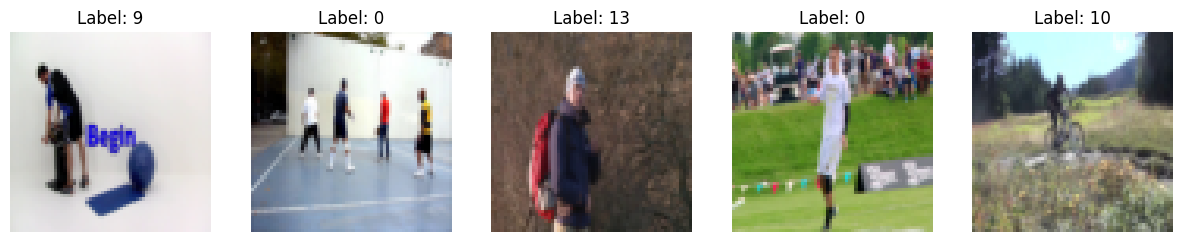

pictures after train_transform:



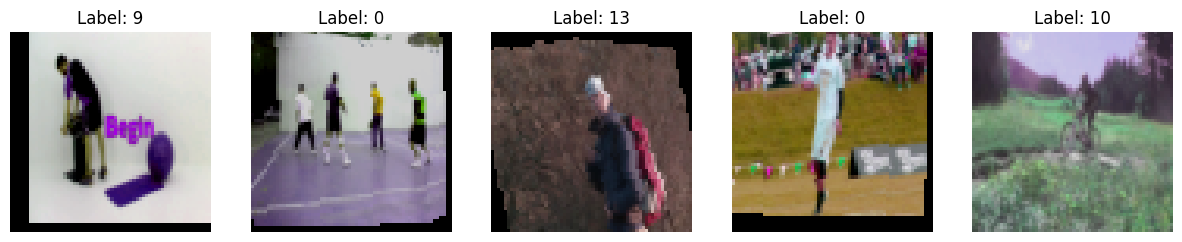

pictures after transform_1:



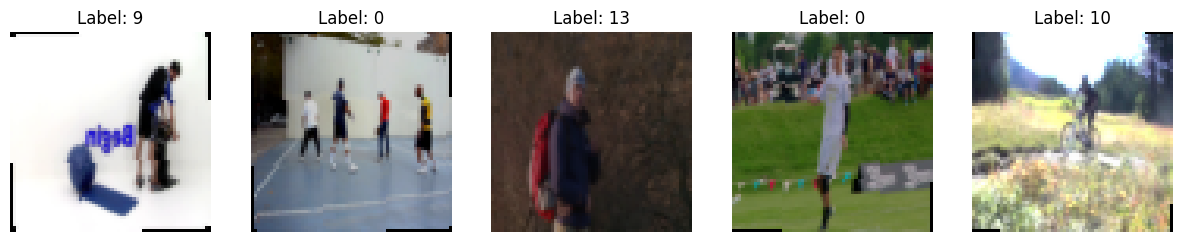

pictures after transform_2:



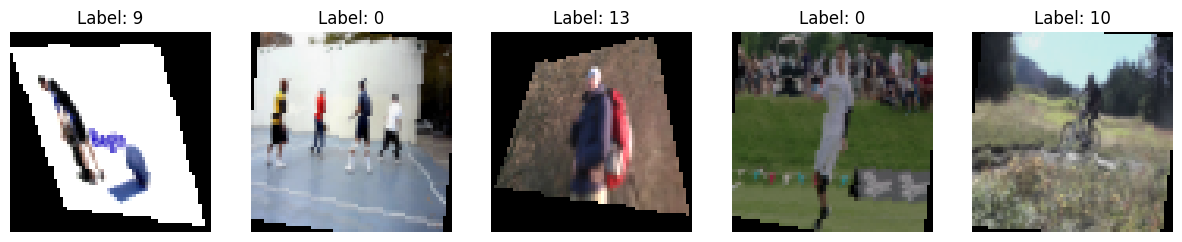

pictures after transform_3:



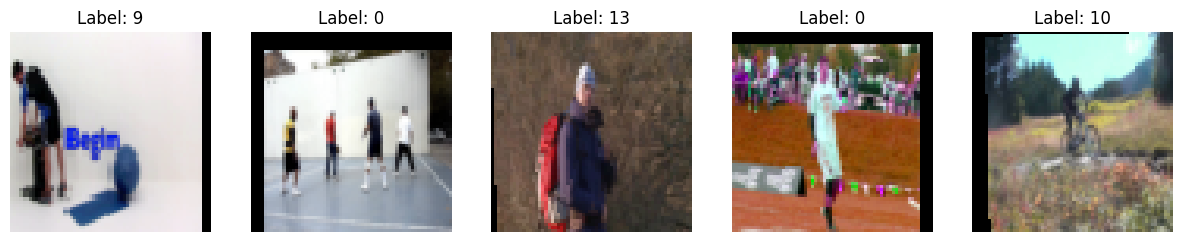

pictures after train_transform_4:



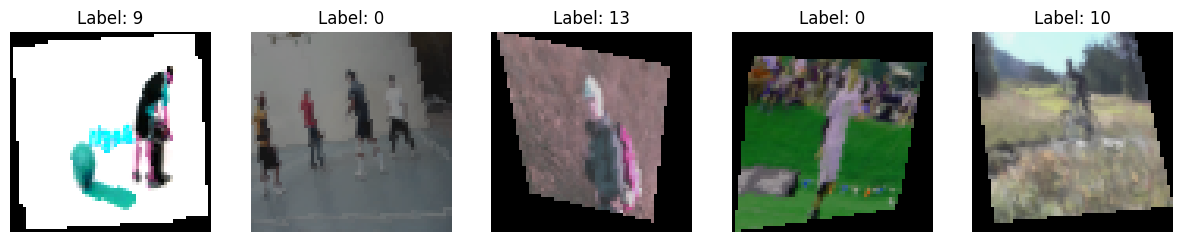

pictures after train_transform_5:



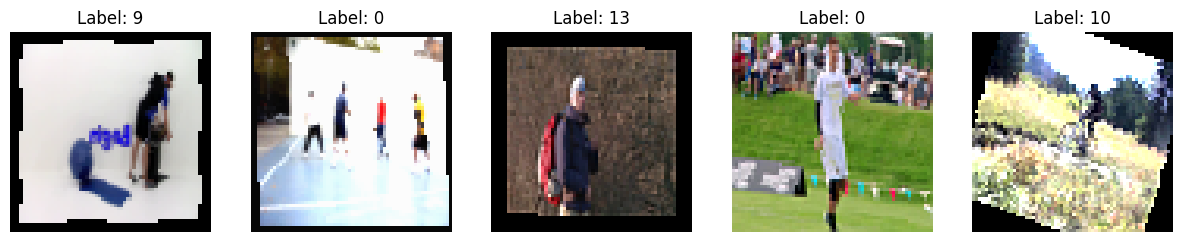

pictures after train_transform_6:



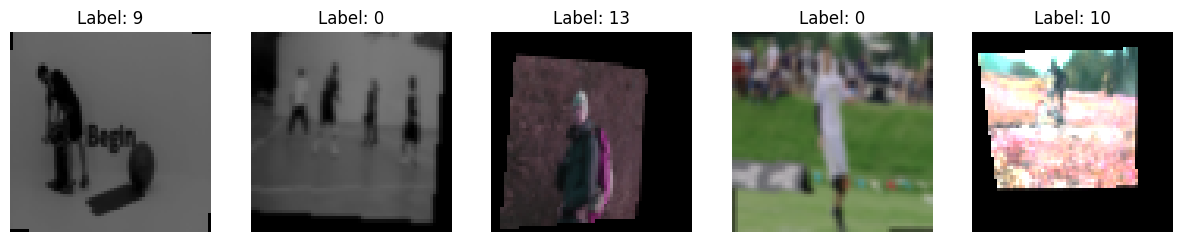

In [118]:
# Посмотрим на картинки в обучающей выборке

def show_images(dataset, num_images=5):
    """Функция для отображения нескольких изображений из датасета"""
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i in range(num_images):
        image, _label = dataset[i]  # Получаем изображение и метку
        # print(image)
        image = image.to(device).unsqueeze(0)
        # print(image)
        image = image.cpu().squeeze().permute(1, 2, 0) * 0.5 + 0.5  # Меняем порядок осей для отображения и обратно нормализуем для отображения (если нормализовали)
        axes[i].imshow(image)
        axes[i].set_title(f"Label: {_label}")
        axes[i].axis("off")
    plt.show()

# Покажем несколько изображений из обучающего набора
print("Original pictures:\n")
show_images(train_dataset_view, num_images=5)
print("pictures after train_transform:\n")
show_images(train_dataset, num_images=5)
print("pictures after transform_1:\n")
show_images(train_dataset_pipeline1, num_images=5)
print("pictures after transform_2:\n")
show_images(train_dataset_pipeline2, num_images=5)
print("pictures after transform_3:\n")
show_images(train_dataset_pipeline3, num_images=5)
print("pictures after train_transform_4:\n")
show_images(train_dataset_pipeline4, num_images=5)
print("pictures after train_transform_5:\n")
show_images(train_dataset_pipeline5, num_images=5)
print("pictures after train_transform_6:\n")
show_images(train_dataset_pipeline6, num_images=5)

In [89]:
# Создадим класс EarlyStopping для контроля переобучения

# class EarlyStopping:
#     def __init__(self, patience=5, delta=0):
#         self.patience = patience
#         self.delta = delta
#         self.best_score = None
#         self.early_stop = False
#         self.counter = 0
#         self.best_model_state = None

#     def __call__(self, val_loss, model):
#         score = -val_loss

#         if self.best_score is None:
#             self.best_score = score
#             self.best_model_state = model.state_dict()
#         elif score < self.best_score + self.delta:
#             self.counter += 1
#             if self.counter >= self.patience:
#                 self.early_stop = True
#         else:
#             self.best_score = score
#             self.best_model_state = model.state_dict()
#             self.counter = 0

#     def load_best_model(self, model):
#         model.load_state_dict(self.best_model_state)

In [119]:
class ImprovedVGG(nn.Module):
    def __init__(self, num_classes=20):
        super(ImprovedVGG, self).__init__()
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(128 * 8 * 8, 512),  # Adjusted for the output size after feature extraction
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(256, num_classes)  # Output layer for the number of classes
        )

    def forward(self, x):
        # print(x.shape)
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.classifier(x)
        return x

In [120]:
# Выведем summary модели
num_classes = len(range(train_labels["target_feature"].min(), train_labels["target_feature"].max()))
print("Кол-во классов:", num_classes)

vgg = ImprovedVGG(num_classes=num_classes + 1).to(device)
print(vgg)

Кол-во классов: 18
ImprovedVGG(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   

In [30]:
# Воспользумся модулем torchviz для красивого отобржения архитектуры

dummy_input = torch.randn(1, 3, 64, 64)

output = vgg(dummy_input)
dot = make_dot(output, params=dict(vgg.named_parameters()))

dot.format = 'png'
dot.render('improvedVGG_model_graph')

'improvedVGG_model_graph.png'

In [31]:
# from IPython.display import Image
# Image(filename='improvedVGG_model_graph.png')

**Изменим функцию обучения с добавлением чекпоинтов + scheduler + early stopping**

[Early stopping](https://www.geeksforgeeks.org/how-to-handle-overfitting-in-pytorch-models-using-early-stopping/) \
[Scheduler](https://coderzcolumn.com/tutorials/artificial-intelligence/pytorch-learning-rate-schedules)

In [14]:
# Функция для визуализации графика ошибок и метрик
def visualize_model_results(train_losses, val_losses, val_metrics, epochs):
    val_acc = [m[0] for m in val_metrics] 
    val_f1 = [m[3] for m in val_metrics]

    plt.figure(figsize=(12, 6)) 
    plt.subplot(1, 2, 1) 
    plt.plot(range(0, epochs), train_losses, label="Train Loss")
    plt.plot(range(0, epochs), val_losses, label="Val Loss")
    plt.xlabel("Epoch") 
    plt.ylabel("Loss") 
    plt.title("Training Loss") 
    plt.legend() 

    plt.subplot(1, 2, 2) 
    plt.plot(val_acc, label="Validation Accuracy") 
    plt.plot(val_f1, label="Validation F1-Score") 
    plt.xlabel("Epoch") 
    plt.ylabel("Value") 
    plt.title("Validation Metrics") 
    plt.legend() 

    plt.tight_layout() 
    plt.show()

In [15]:
# # Early stopping
# early_stopping = EarlyStopping(patience=3, delta=0.01)

# Функция обучения и оценки 

def train_and_evaluate(model, criterion, optimizer, train_loader, val_loader, num_epochs, 
                       lr=1e-3, checkpoint_dir='./checkpoints', checkpoint_path=None):
    train_losses, val_losses = [], []
    val_metrics = []

    os.makedirs(checkpoint_dir, exist_ok=True)
    start_epoch = 0

    scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5, verbose=True)

    # Загрузка чекпоинта, если он указан
    if checkpoint_path is not None:
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch']
        print(f"Resuming training from epoch {start_epoch}")

    try:
        for epoch in range(start_epoch, num_epochs):
            # Обучение
            model.train()
            train_loss = 0
            for images, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Training]'):
                images = images.to(device)
                # images = images.cpu().squeeze().permute(1, 2, 0) * 0.5 + 0.5
                labels = labels.to(device)

                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()

            train_loss /= len(train_loader)
            train_losses.append(train_loss)

            # Оценка
            model.eval()
            val_loss = 0
            all_preds = []
            all_labels = []
            with torch.no_grad():
                for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Validation]"):
                    images = images.to(device)
                    # images = images.cpu().squeeze().permute(1, 2, 0) * 0.5 + 0.5
                    labels = labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()

                    preds = torch.argmax(outputs, dim=1)
                    all_preds.extend(preds.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())

            val_loss /= len(val_loader)
            val_losses.append(val_loss)

            acc = accuracy_score(all_labels, all_preds)
            prec = precision_score(all_labels, all_preds, average="weighted")
            rec = recall_score(all_labels, all_preds, average="weighted")
            f1 = f1_score(all_labels, all_preds, average="weighted")
            val_metrics.append((acc, prec, rec, f1))

            print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                f"Val Acc: {acc:.4f}, Val Prec: {prec:.4f}, Val Recall: {rec:.4f}, Val F1: {f1:.4f}")
            
            scheduler.step(val_loss)

            # Сохранение чекпоинтов
            if (epoch + 1) % 5 == 0:
                checkpoint_path = os.path.join(checkpoint_dir, f"model_epoch{epoch + 1}_acc{acc:.4f}.pth")
                torch.save({'epoch': epoch + 1,
                            'model_state_dict': model.state_dict(),
                            'optimizer_state_dict': optimizer.state_dict(),
                            'val_loss': val_loss}, checkpoint_path)
    except KeyboardInterrupt as key_interrupt_e:
        print(f"Training was interrupted. Residual visualization of passed epochs: {key_interrupt_e}")
        visualize_model_results(train_losses, val_losses, val_metrics, epochs=epoch)
            
        # # Добавляем early stopping
        # early_stopping(val_loss=val_loss, model=model)
        # if early_stopping.early_stop:
        #     print("Early stopping trigered. Training stopped.")
        #     print(f"Model saved at {epoch + 1} epoch.")
        #     torch.save({'epoch': epoch + 1,
        #                 'model_state_dict': model.state_dict(),
        #                 'optimizer_state_dict': optimizer.state_dict(),
        #                 'val_loss': val_loss}, checkpoint_path)
            
        

    return train_losses, val_losses, val_metrics

In [16]:
# Определяем критерий и оптимизатор
criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(vgg.parameters(), lr=lr) 

In [17]:
# Функция для предсказания и сохранения результатов
def predict_and_save(model, test_loader, output_file):
    model.eval()
    predictions = []

    with torch.no_grad():
        for images, ids in tqdm(test_loader):  # img_name_batch нам не нужен для индексации
            images = images.to(device)
            # ids = ids.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            
            for img_id, pred in zip(ids, preds):
                predictions.append((img_id, pred))

    # Создаем DataFrame с индексами и предсказаниями
    results_df = pd.DataFrame(predictions, columns=['id', 'target_feature'])
    results_df['id'] = results_df['id'].str.replace(".jpg", "")

    # Сохраняем файл в формате CSV
    results_df.to_csv(output_file, index=False)
    print(f"Предсказания сохранены в файл {output_file}")

In [201]:
# Сохраняем модель

torch.save(vgg, "vgg.pth")

In [202]:
checkpoint_path = "./checkpoints/model_epoch15_acc0.3668.pth"

In [203]:
# Запуск обучения и валидации. Пример, чтобы посмотреть на изменение
train_losses, val_losses, val_metrics = train_and_evaluate(
    vgg, criterion, optimizer, train_loader, val_loader, num_epochs=75, lr=lr) 

Epoch 1/75 [Validation]: 100%|██████████| 78/78 [00:57<00:00,  1.36it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/75, Train Loss: 2.6753, Val Loss: 2.4793, Val Acc: 0.2119, Val Prec: 0.1341, Val Recall: 0.2119, Val F1: 0.1362


Epoch 2/75 [Validation]: 100%|██████████| 78/78 [00:39<00:00,  1.98it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 2/75, Train Loss: 2.5245, Val Loss: 2.4403, Val Acc: 0.2248, Val Prec: 0.1441, Val Recall: 0.2248, Val F1: 0.1457


Epoch 3/75 [Validation]: 100%|██████████| 78/78 [00:39<00:00,  1.98it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 3/75, Train Loss: 2.4715, Val Loss: 2.3781, Val Acc: 0.2459, Val Prec: 0.2026, Val Recall: 0.2459, Val F1: 0.1670


Epoch 4/75 [Validation]: 100%|██████████| 78/78 [00:39<00:00,  1.99it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 4/75, Train Loss: 2.4418, Val Loss: 2.3476, Val Acc: 0.2584, Val Prec: 0.1550, Val Recall: 0.2584, Val F1: 0.1710


Epoch 5/75 [Validation]: 100%|██████████| 78/78 [00:38<00:00,  2.04it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 5/75, Train Loss: 2.4198, Val Loss: 2.3568, Val Acc: 0.2552, Val Prec: 0.1831, Val Recall: 0.2552, Val F1: 0.1632


Epoch 6/75 [Validation]: 100%|██████████| 78/78 [00:38<00:00,  2.03it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 6/75, Train Loss: 2.3762, Val Loss: 2.3148, Val Acc: 0.2782, Val Prec: 0.2008, Val Recall: 0.2782, Val F1: 0.2121


Epoch 7/75 [Validation]: 100%|██████████| 78/78 [00:34<00:00,  2.24it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 7/75, Train Loss: 2.3642, Val Loss: 2.3314, Val Acc: 0.2632, Val Prec: 0.1927, Val Recall: 0.2632, Val F1: 0.1849


Epoch 8/75 [Validation]: 100%|██████████| 78/78 [00:35<00:00,  2.17it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 8/75, Train Loss: 2.3174, Val Loss: 2.2156, Val Acc: 0.2863, Val Prec: 0.2679, Val Recall: 0.2863, Val F1: 0.2101


Epoch 9/75 [Validation]: 100%|██████████| 78/78 [00:36<00:00,  2.16it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 9/75, Train Loss: 2.2981, Val Loss: 2.2119, Val Acc: 0.2851, Val Prec: 0.2496, Val Recall: 0.2851, Val F1: 0.1964


Epoch 10/75 [Validation]: 100%|██████████| 78/78 [00:34<00:00,  2.24it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 10/75, Train Loss: 2.2809, Val Loss: 2.2028, Val Acc: 0.2960, Val Prec: 0.2651, Val Recall: 0.2960, Val F1: 0.2258


Epoch 11/75 [Validation]: 100%|██████████| 78/78 [00:37<00:00,  2.06it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 11/75, Train Loss: 2.2550, Val Loss: 2.1756, Val Acc: 0.3069, Val Prec: 0.2920, Val Recall: 0.3069, Val F1: 0.2332


Epoch 12/75 [Validation]: 100%|██████████| 78/78 [00:34<00:00,  2.24it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 12/75, Train Loss: 2.2439, Val Loss: 2.1677, Val Acc: 0.2976, Val Prec: 0.2714, Val Recall: 0.2976, Val F1: 0.2317


Epoch 13/75 [Validation]: 100%|██████████| 78/78 [00:36<00:00,  2.16it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 13/75, Train Loss: 2.2178, Val Loss: 2.1666, Val Acc: 0.3114, Val Prec: 0.2909, Val Recall: 0.3114, Val F1: 0.2370


Epoch 14/75 [Validation]: 100%|██████████| 78/78 [00:35<00:00,  2.21it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 14/75, Train Loss: 2.1816, Val Loss: 2.1163, Val Acc: 0.3089, Val Prec: 0.3077, Val Recall: 0.3089, Val F1: 0.2390


Epoch 15/75 [Validation]: 100%|██████████| 78/78 [00:35<00:00,  2.21it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 15/75, Train Loss: 2.1591, Val Loss: 2.0706, Val Acc: 0.3267, Val Prec: 0.3352, Val Recall: 0.3267, Val F1: 0.2608


Epoch 16/75 [Validation]: 100%|██████████| 78/78 [00:35<00:00,  2.19it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 16/75, Train Loss: 2.1314, Val Loss: 2.0945, Val Acc: 0.3247, Val Prec: 0.3265, Val Recall: 0.3247, Val F1: 0.2745


Epoch 17/75 [Validation]: 100%|██████████| 78/78 [00:35<00:00,  2.17it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 17/75, Train Loss: 2.1056, Val Loss: 2.0525, Val Acc: 0.3429, Val Prec: 0.3337, Val Recall: 0.3429, Val F1: 0.2858


Epoch 18/75 [Validation]: 100%|██████████| 78/78 [00:35<00:00,  2.21it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 18/75, Train Loss: 2.0918, Val Loss: 2.0192, Val Acc: 0.3469, Val Prec: 0.3287, Val Recall: 0.3469, Val F1: 0.2826


Epoch 19/75 [Validation]: 100%|██████████| 78/78 [00:42<00:00,  1.85it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 19/75, Train Loss: 2.0713, Val Loss: 2.0087, Val Acc: 0.3522, Val Prec: 0.3210, Val Recall: 0.3522, Val F1: 0.3022


Epoch 20/75 [Validation]: 100%|██████████| 78/78 [00:38<00:00,  2.02it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 20/75, Train Loss: 2.0362, Val Loss: 1.9595, Val Acc: 0.3651, Val Prec: 0.3444, Val Recall: 0.3651, Val F1: 0.3218


Epoch 21/75 [Validation]: 100%|██████████| 78/78 [00:38<00:00,  2.04it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 21/75, Train Loss: 2.0060, Val Loss: 1.9910, Val Acc: 0.3567, Val Prec: 0.3811, Val Recall: 0.3567, Val F1: 0.3070


Epoch 22/75 [Validation]: 100%|██████████| 78/78 [00:37<00:00,  2.08it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 22/75, Train Loss: 1.9684, Val Loss: 1.9556, Val Acc: 0.3757, Val Prec: 0.3531, Val Recall: 0.3757, Val F1: 0.3291


Epoch 23/75 [Validation]: 100%|██████████| 78/78 [00:46<00:00,  1.69it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 23/75, Train Loss: 1.9585, Val Loss: 1.9515, Val Acc: 0.3724, Val Prec: 0.3676, Val Recall: 0.3724, Val F1: 0.3275


Epoch 24/75 [Validation]: 100%|██████████| 78/78 [00:46<00:00,  1.67it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 24/75, Train Loss: 1.9256, Val Loss: 1.9253, Val Acc: 0.3837, Val Prec: 0.3811, Val Recall: 0.3837, Val F1: 0.3425


Epoch 25/75 [Validation]: 100%|██████████| 78/78 [00:41<00:00,  1.88it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 25/75, Train Loss: 1.9199, Val Loss: 1.8991, Val Acc: 0.3841, Val Prec: 0.4338, Val Recall: 0.3841, Val F1: 0.3484


Epoch 26/75 [Validation]: 100%|██████████| 78/78 [00:41<00:00,  1.90it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 26/75, Train Loss: 1.8646, Val Loss: 1.8885, Val Acc: 0.4011, Val Prec: 0.4636, Val Recall: 0.4011, Val F1: 0.3562


Epoch 27/75 [Validation]: 100%|██████████| 78/78 [00:43<00:00,  1.81it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 27/75, Train Loss: 1.8722, Val Loss: 1.8602, Val Acc: 0.3955, Val Prec: 0.3991, Val Recall: 0.3955, Val F1: 0.3504


Epoch 28/75 [Validation]: 100%|██████████| 78/78 [00:38<00:00,  2.03it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 28/75, Train Loss: 1.8372, Val Loss: 1.8832, Val Acc: 0.3926, Val Prec: 0.4476, Val Recall: 0.3926, Val F1: 0.3593


Epoch 29/75 [Validation]: 100%|██████████| 78/78 [00:35<00:00,  2.18it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 29/75, Train Loss: 1.8195, Val Loss: 1.8454, Val Acc: 0.4044, Val Prec: 0.4567, Val Recall: 0.4044, Val F1: 0.3694


Epoch 30/75 [Validation]: 100%|██████████| 78/78 [00:36<00:00,  2.15it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 30/75, Train Loss: 1.8026, Val Loss: 1.8308, Val Acc: 0.4209, Val Prec: 0.4571, Val Recall: 0.4209, Val F1: 0.3889


Epoch 31/75 [Validation]: 100%|██████████| 78/78 [00:35<00:00,  2.20it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 31/75, Train Loss: 1.7688, Val Loss: 1.8114, Val Acc: 0.4173, Val Prec: 0.4685, Val Recall: 0.4173, Val F1: 0.3765


Epoch 32/75 [Validation]: 100%|██████████| 78/78 [00:36<00:00,  2.16it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 32/75, Train Loss: 1.7517, Val Loss: 1.7839, Val Acc: 0.4258, Val Prec: 0.4719, Val Recall: 0.4258, Val F1: 0.3887


Epoch 33/75 [Validation]: 100%|██████████| 78/78 [00:36<00:00,  2.13it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 33/75, Train Loss: 1.7114, Val Loss: 1.7654, Val Acc: 0.4448, Val Prec: 0.5109, Val Recall: 0.4448, Val F1: 0.4142


Epoch 34/75 [Validation]: 100%|██████████| 78/78 [00:35<00:00,  2.23it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 34/75, Train Loss: 1.7103, Val Loss: 1.7654, Val Acc: 0.4395, Val Prec: 0.4891, Val Recall: 0.4395, Val F1: 0.4122


Epoch 35/75 [Validation]: 100%|██████████| 78/78 [00:35<00:00,  2.20it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 35/75, Train Loss: 1.7010, Val Loss: 1.7684, Val Acc: 0.4420, Val Prec: 0.5244, Val Recall: 0.4420, Val F1: 0.4109


Epoch 36/75 [Validation]: 100%|██████████| 78/78 [00:48<00:00,  1.60it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 36/75, Train Loss: 1.6846, Val Loss: 1.7532, Val Acc: 0.4476, Val Prec: 0.5194, Val Recall: 0.4476, Val F1: 0.4235


Epoch 37/75 [Validation]: 100%|██████████| 78/78 [00:45<00:00,  1.73it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 37/75, Train Loss: 1.6488, Val Loss: 1.7625, Val Acc: 0.4383, Val Prec: 0.5192, Val Recall: 0.4383, Val F1: 0.4047


Epoch 38/75 [Validation]: 100%|██████████| 78/78 [00:44<00:00,  1.74it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 38/75, Train Loss: 1.6414, Val Loss: 1.7475, Val Acc: 0.4391, Val Prec: 0.4698, Val Recall: 0.4391, Val F1: 0.4099


Epoch 39/75 [Validation]: 100%|██████████| 78/78 [00:44<00:00,  1.76it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 39/75, Train Loss: 1.6172, Val Loss: 1.7235, Val Acc: 0.4541, Val Prec: 0.5477, Val Recall: 0.4541, Val F1: 0.4274


Epoch 40/75 [Validation]: 100%|██████████| 78/78 [00:36<00:00,  2.15it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 40/75, Train Loss: 1.6098, Val Loss: 1.7234, Val Acc: 0.4594, Val Prec: 0.5506, Val Recall: 0.4594, Val F1: 0.4303


Epoch 41/75 [Validation]: 100%|██████████| 78/78 [00:45<00:00,  1.73it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 41/75, Train Loss: 1.5940, Val Loss: 1.6873, Val Acc: 0.4650, Val Prec: 0.5094, Val Recall: 0.4650, Val F1: 0.4391


Epoch 42/75 [Validation]: 100%|██████████| 78/78 [00:37<00:00,  2.09it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 42/75, Train Loss: 1.5505, Val Loss: 1.6842, Val Acc: 0.4767, Val Prec: 0.5151, Val Recall: 0.4767, Val F1: 0.4488


Epoch 43/75 [Validation]: 100%|██████████| 78/78 [00:36<00:00,  2.12it/s]


Epoch 43/75, Train Loss: 1.5497, Val Loss: 1.6583, Val Acc: 0.4804, Val Prec: 0.5288, Val Recall: 0.4804, Val F1: 0.4551


Epoch 44/75 [Validation]: 100%|██████████| 78/78 [00:41<00:00,  1.88it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 44/75, Train Loss: 1.5232, Val Loss: 1.6924, Val Acc: 0.4577, Val Prec: 0.5020, Val Recall: 0.4577, Val F1: 0.4362


Epoch 45/75 [Validation]: 100%|██████████| 78/78 [00:43<00:00,  1.80it/s]


Epoch 45/75, Train Loss: 1.5183, Val Loss: 1.6978, Val Acc: 0.4683, Val Prec: 0.5290, Val Recall: 0.4683, Val F1: 0.4459


Epoch 46/75 [Validation]: 100%|██████████| 78/78 [00:42<00:00,  1.85it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 46/75, Train Loss: 1.4737, Val Loss: 1.6693, Val Acc: 0.4723, Val Prec: 0.5262, Val Recall: 0.4723, Val F1: 0.4525


Epoch 47/75 [Validation]: 100%|██████████| 78/78 [00:45<00:00,  1.72it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 47/75, Train Loss: 1.4781, Val Loss: 1.6900, Val Acc: 0.4780, Val Prec: 0.5453, Val Recall: 0.4780, Val F1: 0.4553


Epoch 48/75 [Validation]: 100%|██████████| 78/78 [00:44<00:00,  1.77it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 48/75, Train Loss: 1.4826, Val Loss: 1.6648, Val Acc: 0.4751, Val Prec: 0.5300, Val Recall: 0.4751, Val F1: 0.4536


Epoch 49/75 [Validation]: 100%|██████████| 78/78 [00:45<00:00,  1.72it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 49/75, Train Loss: 1.4538, Val Loss: 1.6853, Val Acc: 0.4662, Val Prec: 0.5172, Val Recall: 0.4662, Val F1: 0.4428


Epoch 50/75 [Validation]: 100%|██████████| 78/78 [00:46<00:00,  1.67it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 50/75, Train Loss: 1.3738, Val Loss: 1.6245, Val Acc: 0.4820, Val Prec: 0.5250, Val Recall: 0.4820, Val F1: 0.4678


Epoch 51/75 [Validation]: 100%|██████████| 78/78 [00:43<00:00,  1.78it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 51/75, Train Loss: 1.3518, Val Loss: 1.5971, Val Acc: 0.5026, Val Prec: 0.5334, Val Recall: 0.5026, Val F1: 0.4852


Epoch 52/75 [Validation]: 100%|██████████| 78/78 [00:43<00:00,  1.80it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 52/75, Train Loss: 1.3403, Val Loss: 1.5913, Val Acc: 0.4974, Val Prec: 0.5312, Val Recall: 0.4974, Val F1: 0.4795


Epoch 53/75 [Validation]: 100%|██████████| 78/78 [00:43<00:00,  1.78it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 53/75, Train Loss: 1.3241, Val Loss: 1.5755, Val Acc: 0.5034, Val Prec: 0.5454, Val Recall: 0.5034, Val F1: 0.4904


Epoch 54/75 [Validation]: 100%|██████████| 78/78 [00:36<00:00,  2.15it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 54/75, Train Loss: 1.2957, Val Loss: 1.5855, Val Acc: 0.5111, Val Prec: 0.5579, Val Recall: 0.5111, Val F1: 0.4944


Epoch 55/75 [Validation]: 100%|██████████| 78/78 [00:38<00:00,  2.03it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 55/75, Train Loss: 1.2836, Val Loss: 1.5735, Val Acc: 0.5200, Val Prec: 0.5573, Val Recall: 0.5200, Val F1: 0.5072


Epoch 56/75 [Validation]: 100%|██████████| 78/78 [00:36<00:00,  2.12it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 56/75, Train Loss: 1.2798, Val Loss: 1.5653, Val Acc: 0.5002, Val Prec: 0.5428, Val Recall: 0.5002, Val F1: 0.4883


Epoch 57/75 [Validation]: 100%|██████████| 78/78 [00:36<00:00,  2.15it/s]


Epoch 57/75, Train Loss: 1.2703, Val Loss: 1.5908, Val Acc: 0.5087, Val Prec: 0.5306, Val Recall: 0.5087, Val F1: 0.4913


Epoch 58/75 [Validation]: 100%|██████████| 78/78 [00:36<00:00,  2.11it/s]


Epoch 58/75, Train Loss: 1.2502, Val Loss: 1.6118, Val Acc: 0.5103, Val Prec: 0.5344, Val Recall: 0.5103, Val F1: 0.4978


Epoch 59/75 [Validation]: 100%|██████████| 78/78 [00:38<00:00,  2.05it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 59/75, Train Loss: 1.2361, Val Loss: 1.5582, Val Acc: 0.5180, Val Prec: 0.5379, Val Recall: 0.5180, Val F1: 0.5045


Epoch 60/75 [Validation]: 100%|██████████| 78/78 [00:37<00:00,  2.07it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 60/75, Train Loss: 1.2292, Val Loss: 1.5700, Val Acc: 0.5192, Val Prec: 0.5586, Val Recall: 0.5192, Val F1: 0.5058


Epoch 61/75 [Validation]: 100%|██████████| 78/78 [00:37<00:00,  2.09it/s]


Epoch 61/75, Train Loss: 1.2158, Val Loss: 1.5648, Val Acc: 0.5156, Val Prec: 0.5567, Val Recall: 0.5156, Val F1: 0.5023


Epoch 62/75 [Validation]: 100%|██████████| 78/78 [00:37<00:00,  2.06it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 62/75, Train Loss: 1.2025, Val Loss: 1.5879, Val Acc: 0.5131, Val Prec: 0.5246, Val Recall: 0.5131, Val F1: 0.5004


Epoch 63/75 [Validation]: 100%|██████████| 78/78 [00:41<00:00,  1.86it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 63/75, Train Loss: 1.1963, Val Loss: 1.5619, Val Acc: 0.5127, Val Prec: 0.5486, Val Recall: 0.5127, Val F1: 0.4994


Epoch 64/75 [Validation]: 100%|██████████| 78/78 [00:43<00:00,  1.81it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 64/75, Train Loss: 1.2005, Val Loss: 1.5219, Val Acc: 0.5285, Val Prec: 0.5562, Val Recall: 0.5285, Val F1: 0.5185


Epoch 65/75 [Validation]: 100%|██████████| 78/78 [00:43<00:00,  1.78it/s]


Epoch 65/75, Train Loss: 1.1769, Val Loss: 1.5210, Val Acc: 0.5334, Val Prec: 0.5507, Val Recall: 0.5334, Val F1: 0.5197


Epoch 66/75 [Validation]: 100%|██████████| 78/78 [00:41<00:00,  1.87it/s]


Epoch 66/75, Train Loss: 1.1594, Val Loss: 1.5746, Val Acc: 0.5293, Val Prec: 0.5548, Val Recall: 0.5293, Val F1: 0.5179


Epoch 67/75 [Validation]: 100%|██████████| 78/78 [00:42<00:00,  1.84it/s]


Epoch 67/75, Train Loss: 1.1574, Val Loss: 1.5358, Val Acc: 0.5358, Val Prec: 0.5567, Val Recall: 0.5358, Val F1: 0.5246


Epoch 68/75 [Validation]: 100%|██████████| 78/78 [00:43<00:00,  1.79it/s]


Epoch 68/75, Train Loss: 1.1644, Val Loss: 1.5195, Val Acc: 0.5410, Val Prec: 0.5746, Val Recall: 0.5410, Val F1: 0.5336


Epoch 69/75 [Validation]: 100%|██████████| 78/78 [00:42<00:00,  1.85it/s]


Epoch 69/75, Train Loss: 1.1474, Val Loss: 1.5099, Val Acc: 0.5346, Val Prec: 0.5588, Val Recall: 0.5346, Val F1: 0.5243


Epoch 70/75 [Validation]: 100%|██████████| 78/78 [00:39<00:00,  1.97it/s]


Epoch 70/75, Train Loss: 1.1282, Val Loss: 1.5290, Val Acc: 0.5419, Val Prec: 0.5646, Val Recall: 0.5419, Val F1: 0.5321


Epoch 71/75 [Validation]: 100%|██████████| 78/78 [00:43<00:00,  1.80it/s]


Epoch 71/75, Train Loss: 1.1197, Val Loss: 1.5271, Val Acc: 0.5398, Val Prec: 0.5672, Val Recall: 0.5398, Val F1: 0.5307


Epoch 72/75 [Validation]: 100%|██████████| 78/78 [00:43<00:00,  1.80it/s]


Epoch 72/75, Train Loss: 1.1084, Val Loss: 1.5370, Val Acc: 0.5317, Val Prec: 0.5535, Val Recall: 0.5317, Val F1: 0.5193


Epoch 73/75 [Validation]: 100%|██████████| 78/78 [00:38<00:00,  2.04it/s]


Epoch 73/75, Train Loss: 1.0897, Val Loss: 1.4985, Val Acc: 0.5483, Val Prec: 0.5830, Val Recall: 0.5483, Val F1: 0.5382


Epoch 74/75 [Validation]: 100%|██████████| 78/78 [00:41<00:00,  1.86it/s]


Epoch 74/75, Train Loss: 1.0984, Val Loss: 1.4709, Val Acc: 0.5475, Val Prec: 0.5761, Val Recall: 0.5475, Val F1: 0.5373


Epoch 75/75 [Validation]: 100%|██████████| 78/78 [00:44<00:00,  1.76it/s]


Epoch 75/75, Train Loss: 1.0970, Val Loss: 1.5210, Val Acc: 0.5467, Val Prec: 0.5568, Val Recall: 0.5467, Val F1: 0.5361


In [204]:
torch.save(vgg.state_dict(), 'final_vgg_75.pth')

In [44]:
# vgg = torch.load("final_vgg_75.pth")

train_losses, val_losses, val_metrics = train_and_evaluate(
    vgg, criterion, optimizer, train_loader, val_loader, num_epochs=100, lr=lr, checkpoint_path='./checkpoints/model_epoch75_acc0.5467.pth')


Resuming training from epoch 75


Epoch 76/100 [Validation]: 100%|██████████| 78/78 [00:38<00:00,  2.01it/s]


Epoch 76/100, Train Loss: 1.2280, Val Loss: 0.9335, Val Acc: 0.7153, Val Prec: 0.7461, Val Recall: 0.7153, Val F1: 0.7117


Epoch 77/100 [Validation]: 100%|██████████| 78/78 [00:38<00:00,  2.04it/s]


Epoch 77/100, Train Loss: 1.2202, Val Loss: 0.9021, Val Acc: 0.7250, Val Prec: 0.7454, Val Recall: 0.7250, Val F1: 0.7217


Epoch 78/100 [Validation]: 100%|██████████| 78/78 [00:37<00:00,  2.07it/s]


Epoch 78/100, Train Loss: 1.2339, Val Loss: 0.9236, Val Acc: 0.7133, Val Prec: 0.7358, Val Recall: 0.7133, Val F1: 0.7080


Epoch 79/100 [Validation]: 100%|██████████| 78/78 [00:38<00:00,  2.04it/s]


Epoch 79/100, Train Loss: 1.2408, Val Loss: 0.9228, Val Acc: 0.7157, Val Prec: 0.7367, Val Recall: 0.7157, Val F1: 0.7129


Epoch 80/100 [Validation]: 100%|██████████| 78/78 [00:37<00:00,  2.07it/s]


Epoch 80/100, Train Loss: 1.2438, Val Loss: 0.9289, Val Acc: 0.7165, Val Prec: 0.7412, Val Recall: 0.7165, Val F1: 0.7133


Epoch 81/100 [Validation]: 100%|██████████| 78/78 [00:36<00:00,  2.12it/s]


Epoch 81/100, Train Loss: 1.2422, Val Loss: 0.9091, Val Acc: 0.7279, Val Prec: 0.7472, Val Recall: 0.7279, Val F1: 0.7251


Epoch 82/100 [Validation]: 100%|██████████| 78/78 [00:38<00:00,  2.05it/s]


Epoch 82/100, Train Loss: 1.2421, Val Loss: 0.9364, Val Acc: 0.7080, Val Prec: 0.7252, Val Recall: 0.7080, Val F1: 0.7035


Epoch 83/100 [Validation]: 100%|██████████| 78/78 [00:36<00:00,  2.11it/s]


Epoch 83/100, Train Loss: 1.2212, Val Loss: 0.9495, Val Acc: 0.7161, Val Prec: 0.7409, Val Recall: 0.7161, Val F1: 0.7101


Epoch 84/100 [Validation]: 100%|██████████| 78/78 [00:36<00:00,  2.11it/s]


Epoch 84/100, Train Loss: 1.2400, Val Loss: 0.9271, Val Acc: 0.7327, Val Prec: 0.7536, Val Recall: 0.7327, Val F1: 0.7266


Epoch 85/100 [Validation]: 100%|██████████| 78/78 [00:37<00:00,  2.10it/s]


Epoch 85/100, Train Loss: 1.2100, Val Loss: 0.9143, Val Acc: 0.7186, Val Prec: 0.7377, Val Recall: 0.7186, Val F1: 0.7138


Epoch 86/100 [Validation]: 100%|██████████| 78/78 [00:37<00:00,  2.10it/s]


Epoch 86/100, Train Loss: 1.2476, Val Loss: 0.9375, Val Acc: 0.7214, Val Prec: 0.7378, Val Recall: 0.7214, Val F1: 0.7175


Epoch 87/100 [Validation]: 100%|██████████| 78/78 [00:36<00:00,  2.14it/s]


Epoch 87/100, Train Loss: 1.2373, Val Loss: 0.9239, Val Acc: 0.7137, Val Prec: 0.7352, Val Recall: 0.7137, Val F1: 0.7096


Epoch 88/100 [Validation]: 100%|██████████| 78/78 [00:36<00:00,  2.13it/s]


Epoch 88/100, Train Loss: 1.2455, Val Loss: 0.9180, Val Acc: 0.7129, Val Prec: 0.7298, Val Recall: 0.7129, Val F1: 0.7081


Epoch 89/100 [Validation]: 100%|██████████| 78/78 [00:48<00:00,  1.61it/s]


Epoch 89/100, Train Loss: 1.2072, Val Loss: 0.9206, Val Acc: 0.7218, Val Prec: 0.7434, Val Recall: 0.7218, Val F1: 0.7176


Epoch 90/100 [Validation]: 100%|██████████| 78/78 [00:50<00:00,  1.54it/s]


Epoch 90/100, Train Loss: 1.2157, Val Loss: 0.9459, Val Acc: 0.7133, Val Prec: 0.7394, Val Recall: 0.7133, Val F1: 0.7094


Epoch 91/100 [Validation]: 100%|██████████| 78/78 [00:41<00:00,  1.88it/s]


Epoch 91/100, Train Loss: 1.2339, Val Loss: 0.9005, Val Acc: 0.7238, Val Prec: 0.7428, Val Recall: 0.7238, Val F1: 0.7198


Epoch 92/100 [Validation]: 100%|██████████| 78/78 [00:48<00:00,  1.60it/s]


Epoch 92/100, Train Loss: 1.2234, Val Loss: 0.9530, Val Acc: 0.7165, Val Prec: 0.7434, Val Recall: 0.7165, Val F1: 0.7114


Epoch 93/100 [Validation]: 100%|██████████| 78/78 [00:41<00:00,  1.86it/s]


Epoch 93/100, Train Loss: 1.2274, Val Loss: 0.9146, Val Acc: 0.7198, Val Prec: 0.7410, Val Recall: 0.7198, Val F1: 0.7152


Epoch 94/100 [Validation]: 100%|██████████| 78/78 [00:45<00:00,  1.73it/s]


Epoch 94/100, Train Loss: 1.2476, Val Loss: 0.9382, Val Acc: 0.7113, Val Prec: 0.7298, Val Recall: 0.7113, Val F1: 0.7074


Epoch 95/100 [Validation]: 100%|██████████| 78/78 [00:47<00:00,  1.63it/s]


Epoch 95/100, Train Loss: 1.2414, Val Loss: 0.9303, Val Acc: 0.7153, Val Prec: 0.7358, Val Recall: 0.7153, Val F1: 0.7104


Epoch 96/100 [Validation]: 100%|██████████| 78/78 [00:46<00:00,  1.69it/s]


Epoch 96/100, Train Loss: 1.2372, Val Loss: 0.9394, Val Acc: 0.7169, Val Prec: 0.7390, Val Recall: 0.7169, Val F1: 0.7123


Epoch 97/100 [Validation]: 100%|██████████| 78/78 [00:47<00:00,  1.64it/s]


Epoch 97/100, Train Loss: 1.2165, Val Loss: 0.9044, Val Acc: 0.7250, Val Prec: 0.7466, Val Recall: 0.7250, Val F1: 0.7215


Epoch 98/100 [Validation]: 100%|██████████| 78/78 [00:47<00:00,  1.64it/s]


Epoch 98/100, Train Loss: 1.2428, Val Loss: 0.9298, Val Acc: 0.7230, Val Prec: 0.7391, Val Recall: 0.7230, Val F1: 0.7200


Epoch 99/100 [Validation]: 100%|██████████| 78/78 [00:36<00:00,  2.11it/s]


Epoch 99/100, Train Loss: 1.2352, Val Loss: 0.9196, Val Acc: 0.7202, Val Prec: 0.7453, Val Recall: 0.7202, Val F1: 0.7151


Epoch 100/100 [Validation]: 100%|██████████| 78/78 [00:38<00:00,  2.04it/s]

Epoch 100/100, Train Loss: 1.2260, Val Loss: 0.9258, Val Acc: 0.7262, Val Prec: 0.7480, Val Recall: 0.7262, Val F1: 0.7215


In [45]:
# После обучения производим предсказания и сохраняем их в требуемый формат
output_file = "test_predictions_100.csv"
predict_and_save(vgg, test_loader, output_file) 

100%|██████████| 166/166 [00:50<00:00,  3.29it/s]

Предсказания сохранены в файл test_predictions_100.csv


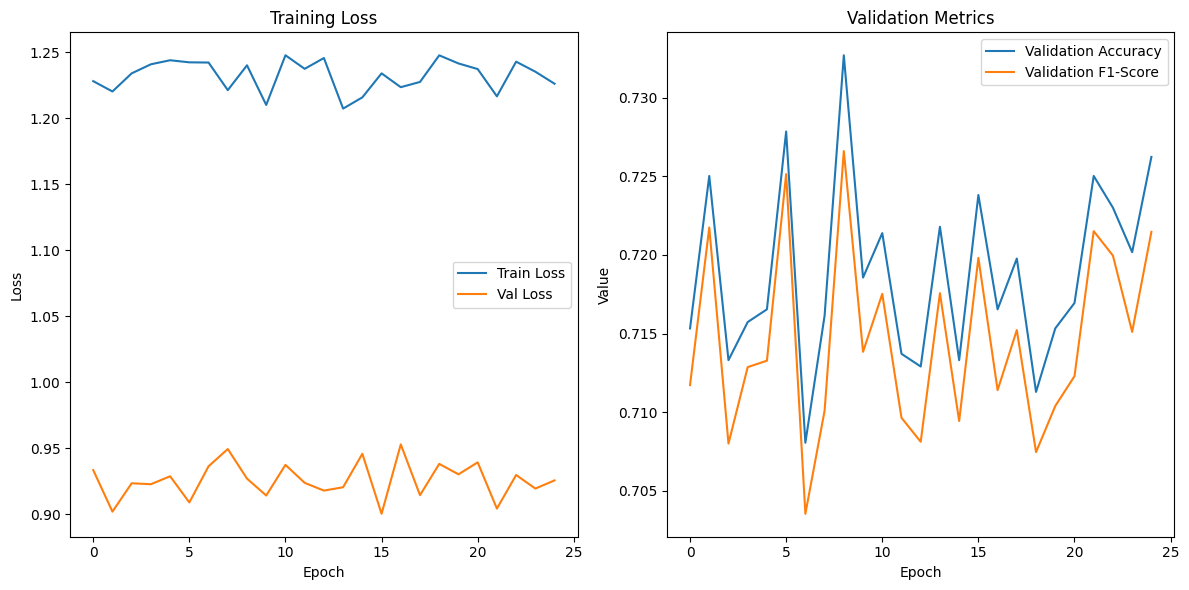

In [48]:
# Визуализация

visualize_model_results(train_losses, val_losses, val_metrics, epochs=25)

In [49]:
torch.save(vgg.state_dict(), 'final_vgg_100.pth')

## Эксперементируем с новыми пайплайнами



In [ ]:
# torch.save(vgg.state_dict(), 'final_vgg_зipeline1.pth')

In [124]:
# vgg = torch.load("final_vgg_75.pth")

train_losses_pipeline1, val_losses_pipeline1, val_metrics_pipeline1 = train_and_evaluate(
    vgg, criterion, optimizer, train_loader1, val_loader1, num_epochs=75, lr=lr)


c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
Epoch 1/75 [Validation]: 100%|██████████| 78/78 [00:27<00:00,  2.84it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/75, Train Loss: 2.6567, Val Loss: 2.4621, Val Acc: 0.2333, Val Prec: 0.1796, Val Recall: 0.2333, Val F1: 0.1465


Epoch 2/75 [Validation]: 100%|██████████| 78/78 [00:25<00:00,  3.02it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 2/75, Train Loss: 2.4864, Val Loss: 2.3855, Val Acc: 0.2285, Val Prec: 0.1652, Val Recall: 0.2285, Val F1: 0.1625


Epoch 3/75 [Validation]: 100%|██████████| 78/78 [00:23<00:00,  3.27it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 3/75, Train Loss: 2.4442, Val Loss: 2.2880, Val Acc: 0.2653, Val Prec: 0.2597, Val Recall: 0.2653, Val F1: 0.1899


Epoch 4/75 [Validation]: 100%|██████████| 78/78 [00:23<00:00,  3.26it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 4/75, Train Loss: 2.3770, Val Loss: 2.2556, Val Acc: 0.2936, Val Prec: 0.2664, Val Recall: 0.2936, Val F1: 0.2036


Epoch 5/75 [Validation]: 100%|██████████| 78/78 [00:30<00:00,  2.59it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 5/75, Train Loss: 2.3390, Val Loss: 2.2248, Val Acc: 0.2932, Val Prec: 0.3096, Val Recall: 0.2932, Val F1: 0.2323


Epoch 6/75 [Validation]: 100%|██████████| 78/78 [00:26<00:00,  2.98it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 6/75, Train Loss: 2.2975, Val Loss: 2.2005, Val Acc: 0.3029, Val Prec: 0.3127, Val Recall: 0.3029, Val F1: 0.2374


Epoch 7/75 [Validation]: 100%|██████████| 78/78 [00:28<00:00,  2.75it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 7/75, Train Loss: 2.2607, Val Loss: 2.1498, Val Acc: 0.3110, Val Prec: 0.3283, Val Recall: 0.3110, Val F1: 0.2474


Epoch 8/75 [Validation]: 100%|██████████| 78/78 [00:28<00:00,  2.73it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 8/75, Train Loss: 2.2315, Val Loss: 2.1467, Val Acc: 0.3279, Val Prec: 0.3474, Val Recall: 0.3279, Val F1: 0.2609


Epoch 9/75 [Validation]: 100%|██████████| 78/78 [00:24<00:00,  3.24it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 9/75, Train Loss: 2.2064, Val Loss: 2.1096, Val Acc: 0.3401, Val Prec: 0.3385, Val Recall: 0.3401, Val F1: 0.2711


Epoch 10/75 [Validation]: 100%|██████████| 78/78 [00:25<00:00,  3.11it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 10/75, Train Loss: 2.1627, Val Loss: 2.0656, Val Acc: 0.3441, Val Prec: 0.3713, Val Recall: 0.3441, Val F1: 0.2946


Epoch 11/75 [Validation]: 100%|██████████| 78/78 [00:25<00:00,  3.10it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 11/75, Train Loss: 2.1185, Val Loss: 2.0922, Val Acc: 0.3518, Val Prec: 0.3766, Val Recall: 0.3518, Val F1: 0.2995


Epoch 12/75 [Validation]: 100%|██████████| 78/78 [00:24<00:00,  3.16it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 12/75, Train Loss: 2.1024, Val Loss: 2.0076, Val Acc: 0.3635, Val Prec: 0.3732, Val Recall: 0.3635, Val F1: 0.3247


Epoch 13/75 [Validation]: 100%|██████████| 78/78 [00:23<00:00,  3.26it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 13/75, Train Loss: 2.0488, Val Loss: 1.9363, Val Acc: 0.3846, Val Prec: 0.3827, Val Recall: 0.3846, Val F1: 0.3367


Epoch 14/75 [Validation]: 100%|██████████| 78/78 [00:23<00:00,  3.27it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 14/75, Train Loss: 2.0167, Val Loss: 1.9588, Val Acc: 0.3704, Val Prec: 0.3688, Val Recall: 0.3704, Val F1: 0.3299


Epoch 15/75 [Validation]: 100%|██████████| 78/78 [00:29<00:00,  2.67it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 15/75, Train Loss: 1.9496, Val Loss: 1.8967, Val Acc: 0.4003, Val Prec: 0.3907, Val Recall: 0.4003, Val F1: 0.3620


Epoch 16/75 [Validation]: 100%|██████████| 78/78 [00:23<00:00,  3.26it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 16/75, Train Loss: 1.9202, Val Loss: 1.8736, Val Acc: 0.4023, Val Prec: 0.4449, Val Recall: 0.4023, Val F1: 0.3630


Epoch 17/75 [Validation]: 100%|██████████| 78/78 [00:23<00:00,  3.26it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 17/75, Train Loss: 1.8667, Val Loss: 1.8331, Val Acc: 0.4185, Val Prec: 0.4760, Val Recall: 0.4185, Val F1: 0.3814


Epoch 18/75 [Validation]: 100%|██████████| 78/78 [00:23<00:00,  3.26it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 18/75, Train Loss: 1.7947, Val Loss: 1.7541, Val Acc: 0.4541, Val Prec: 0.5026, Val Recall: 0.4541, Val F1: 0.4279


Epoch 19/75 [Validation]: 100%|██████████| 78/78 [00:23<00:00,  3.25it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 19/75, Train Loss: 1.7353, Val Loss: 1.7209, Val Acc: 0.4549, Val Prec: 0.5033, Val Recall: 0.4549, Val F1: 0.4276


Epoch 20/75 [Validation]: 100%|██████████| 78/78 [00:23<00:00,  3.27it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 20/75, Train Loss: 1.7068, Val Loss: 1.7191, Val Acc: 0.4533, Val Prec: 0.4897, Val Recall: 0.4533, Val F1: 0.4328


Epoch 21/75 [Validation]: 100%|██████████| 78/78 [00:23<00:00,  3.26it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 21/75, Train Loss: 1.6299, Val Loss: 1.7164, Val Acc: 0.4634, Val Prec: 0.5132, Val Recall: 0.4634, Val F1: 0.4397


Epoch 22/75 [Validation]: 100%|██████████| 78/78 [00:24<00:00,  3.24it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 22/75, Train Loss: 1.5708, Val Loss: 1.6660, Val Acc: 0.4707, Val Prec: 0.5077, Val Recall: 0.4707, Val F1: 0.4434


Epoch 23/75 [Validation]: 100%|██████████| 78/78 [00:23<00:00,  3.25it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 23/75, Train Loss: 1.5304, Val Loss: 1.6431, Val Acc: 0.4719, Val Prec: 0.5007, Val Recall: 0.4719, Val F1: 0.4523


Epoch 24/75 [Validation]: 100%|██████████| 78/78 [00:24<00:00,  3.24it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 24/75, Train Loss: 1.4446, Val Loss: 1.6490, Val Acc: 0.4828, Val Prec: 0.4991, Val Recall: 0.4828, Val F1: 0.4573


Epoch 25/75 [Validation]: 100%|██████████| 78/78 [00:23<00:00,  3.26it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 25/75, Train Loss: 1.3986, Val Loss: 1.6129, Val Acc: 0.5018, Val Prec: 0.5540, Val Recall: 0.5018, Val F1: 0.4825


Epoch 26/75 [Training]:  10%|█         | 31/310 [00:11<01:45,  2.64it/s]


KeyboardInterrupt: 

In [21]:
train_losses_pipeline1, val_losses_pipeline1, val_metrics_pipeline1 = train_and_evaluate(
    vgg, criterion, optimizer, train_loader1, val_loader1, num_epochs=75, lr=lr, checkpoint_path='./checkpoints/model_epoch25_acc0.5018.pth')

c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Resuming training from epoch 25


Epoch 26/75 [Validation]: 100%|██████████| 78/78 [00:34<00:00,  2.27it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 26/75, Train Loss: 1.4599, Val Loss: 1.2258, Val Acc: 0.6146, Val Prec: 0.6769, Val Recall: 0.6146, Val F1: 0.5997


Epoch 27/75 [Validation]: 100%|██████████| 78/78 [00:25<00:00,  3.10it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 27/75, Train Loss: 1.3895, Val Loss: 1.2106, Val Acc: 0.6264, Val Prec: 0.6731, Val Recall: 0.6264, Val F1: 0.6165


Epoch 28/75 [Validation]: 100%|██████████| 78/78 [00:25<00:00,  3.10it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 28/75, Train Loss: 1.3271, Val Loss: 1.1989, Val Acc: 0.6300, Val Prec: 0.6597, Val Recall: 0.6300, Val F1: 0.6155


Epoch 29/75 [Validation]: 100%|██████████| 78/78 [00:25<00:00,  3.08it/s]


Epoch 29/75, Train Loss: 1.2591, Val Loss: 1.1915, Val Acc: 0.6207, Val Prec: 0.6624, Val Recall: 0.6207, Val F1: 0.6131


Epoch 30/75 [Validation]: 100%|██████████| 78/78 [00:25<00:00,  3.10it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 30/75, Train Loss: 1.2132, Val Loss: 1.2016, Val Acc: 0.6106, Val Prec: 0.6492, Val Recall: 0.6106, Val F1: 0.5998


Epoch 31/75 [Validation]: 100%|██████████| 78/78 [00:25<00:00,  3.09it/s]


Epoch 31/75, Train Loss: 1.1567, Val Loss: 1.2083, Val Acc: 0.6106, Val Prec: 0.6400, Val Recall: 0.6106, Val F1: 0.6010


Epoch 32/75 [Validation]: 100%|██████████| 78/78 [00:25<00:00,  3.12it/s]


Epoch 32/75, Train Loss: 1.1099, Val Loss: 1.1699, Val Acc: 0.6235, Val Prec: 0.6492, Val Recall: 0.6235, Val F1: 0.6139


Epoch 33/75 [Validation]: 100%|██████████| 78/78 [00:25<00:00,  3.10it/s]


Epoch 33/75, Train Loss: 1.0557, Val Loss: 1.1725, Val Acc: 0.6223, Val Prec: 0.6440, Val Recall: 0.6223, Val F1: 0.6092


Epoch 34/75 [Validation]: 100%|██████████| 78/78 [00:25<00:00,  3.10it/s]


Epoch 34/75, Train Loss: 1.0108, Val Loss: 1.1896, Val Acc: 0.6231, Val Prec: 0.6387, Val Recall: 0.6231, Val F1: 0.6164


Epoch 35/75 [Validation]: 100%|██████████| 78/78 [00:25<00:00,  3.08it/s]


Epoch 35/75, Train Loss: 0.9701, Val Loss: 1.1923, Val Acc: 0.6195, Val Prec: 0.6588, Val Recall: 0.6195, Val F1: 0.6129


Epoch 36/75 [Validation]: 100%|██████████| 78/78 [00:25<00:00,  3.11it/s]


Epoch 36/75, Train Loss: 0.9459, Val Loss: 1.1907, Val Acc: 0.6183, Val Prec: 0.6470, Val Recall: 0.6183, Val F1: 0.6123


Epoch 37/75 [Validation]: 100%|██████████| 78/78 [00:25<00:00,  3.09it/s]


Epoch 37/75, Train Loss: 0.8902, Val Loss: 1.2093, Val Acc: 0.6171, Val Prec: 0.6545, Val Recall: 0.6171, Val F1: 0.6100


Epoch 38/75 [Validation]: 100%|██████████| 78/78 [00:25<00:00,  3.09it/s]


Epoch 38/75, Train Loss: 0.8772, Val Loss: 1.1868, Val Acc: 0.6247, Val Prec: 0.6541, Val Recall: 0.6247, Val F1: 0.6204


Epoch 39/75 [Validation]: 100%|██████████| 78/78 [00:25<00:00,  3.09it/s]


Epoch 39/75, Train Loss: 0.7611, Val Loss: 1.1528, Val Acc: 0.6385, Val Prec: 0.6616, Val Recall: 0.6385, Val F1: 0.6347


Epoch 40/75 [Validation]: 100%|██████████| 78/78 [00:25<00:00,  3.10it/s]


Epoch 40/75, Train Loss: 0.7288, Val Loss: 1.1315, Val Acc: 0.6466, Val Prec: 0.6721, Val Recall: 0.6466, Val F1: 0.6418


Epoch 41/75 [Validation]: 100%|██████████| 78/78 [00:32<00:00,  2.44it/s]


Epoch 41/75, Train Loss: 0.6777, Val Loss: 1.1407, Val Acc: 0.6353, Val Prec: 0.6692, Val Recall: 0.6353, Val F1: 0.6294


Epoch 42/75 [Validation]: 100%|██████████| 78/78 [00:36<00:00,  2.13it/s]


Epoch 42/75, Train Loss: 0.6458, Val Loss: 1.1561, Val Acc: 0.6482, Val Prec: 0.6624, Val Recall: 0.6482, Val F1: 0.6420


Epoch 43/75 [Validation]: 100%|██████████| 78/78 [00:36<00:00,  2.11it/s]


Epoch 43/75, Train Loss: 0.6472, Val Loss: 1.2049, Val Acc: 0.6300, Val Prec: 0.6529, Val Recall: 0.6300, Val F1: 0.6271


Epoch 44/75 [Validation]: 100%|██████████| 78/78 [00:37<00:00,  2.08it/s]


Epoch 44/75, Train Loss: 0.5998, Val Loss: 1.1798, Val Acc: 0.6389, Val Prec: 0.6514, Val Recall: 0.6389, Val F1: 0.6341


Epoch 45/75 [Validation]: 100%|██████████| 78/78 [00:36<00:00,  2.12it/s]


Epoch 45/75, Train Loss: 0.5960, Val Loss: 1.1444, Val Acc: 0.6506, Val Prec: 0.6722, Val Recall: 0.6506, Val F1: 0.6463


Epoch 46/75 [Validation]: 100%|██████████| 78/78 [00:37<00:00,  2.08it/s]


Epoch 46/75, Train Loss: 0.5718, Val Loss: 1.1782, Val Acc: 0.6405, Val Prec: 0.6541, Val Recall: 0.6405, Val F1: 0.6356


Epoch 47/75 [Validation]: 100%|██████████| 78/78 [00:37<00:00,  2.07it/s]


Epoch 47/75, Train Loss: 0.5178, Val Loss: 1.1739, Val Acc: 0.6490, Val Prec: 0.6625, Val Recall: 0.6490, Val F1: 0.6475


Epoch 48/75 [Validation]: 100%|██████████| 78/78 [00:23<00:00,  3.25it/s]


Epoch 48/75, Train Loss: 0.5078, Val Loss: 1.1592, Val Acc: 0.6571, Val Prec: 0.6704, Val Recall: 0.6571, Val F1: 0.6520


Epoch 49/75 [Validation]: 100%|██████████| 78/78 [00:24<00:00,  3.24it/s]


Epoch 49/75, Train Loss: 0.4892, Val Loss: 1.1589, Val Acc: 0.6522, Val Prec: 0.6613, Val Recall: 0.6522, Val F1: 0.6486


Epoch 50/75 [Validation]: 100%|██████████| 78/78 [00:24<00:00,  3.24it/s]


Epoch 50/75, Train Loss: 0.4747, Val Loss: 1.1798, Val Acc: 0.6413, Val Prec: 0.6596, Val Recall: 0.6413, Val F1: 0.6404


Epoch 51/75 [Validation]: 100%|██████████| 78/78 [00:24<00:00,  3.24it/s]


Epoch 51/75, Train Loss: 0.4642, Val Loss: 1.1778, Val Acc: 0.6462, Val Prec: 0.6612, Val Recall: 0.6462, Val F1: 0.6425


Epoch 52/75 [Validation]: 100%|██████████| 78/78 [00:24<00:00,  3.24it/s]


Epoch 52/75, Train Loss: 0.4478, Val Loss: 1.2176, Val Acc: 0.6494, Val Prec: 0.6632, Val Recall: 0.6494, Val F1: 0.6474


Epoch 53/75 [Validation]: 100%|██████████| 78/78 [00:28<00:00,  2.71it/s]


Epoch 53/75, Train Loss: 0.4315, Val Loss: 1.1711, Val Acc: 0.6624, Val Prec: 0.6740, Val Recall: 0.6624, Val F1: 0.6604


Epoch 54/75 [Validation]: 100%|██████████| 78/78 [00:28<00:00,  2.79it/s]


Epoch 54/75, Train Loss: 0.4195, Val Loss: 1.1760, Val Acc: 0.6535, Val Prec: 0.6677, Val Recall: 0.6535, Val F1: 0.6517


Epoch 55/75 [Validation]: 100%|██████████| 78/78 [00:28<00:00,  2.76it/s]


Epoch 55/75, Train Loss: 0.4193, Val Loss: 1.1898, Val Acc: 0.6591, Val Prec: 0.6687, Val Recall: 0.6591, Val F1: 0.6562


Epoch 56/75 [Training]:  12%|█▏        | 37/310 [00:15<01:57,  2.32it/s]


KeyboardInterrupt: 

In [23]:
visualize_model_results(train_losses_pipeline1, val_losses_pipeline1, val_metrics_pipeline1, num_epochs=30)

NameError: name 'train_losses_pipeline1' is not defined

In [28]:
torch.save(vgg.state_dict(), 'vgg_pipeline1_55.pth')

AttributeError: 'NoneType' object has no attribute 'state_dict'

In [34]:
rain_losses_pipeline1, val_losses_pipeline1, val_metrics_pipeline1 = train_and_evaluate(
    vgg, criterion, optimizer, train_loader1, val_loader1, num_epochs=75, lr=lr, checkpoint_path='./checkpoints/model_epoch55_acc0.6591.pth')

Resuming training from epoch 55


Epoch 56/75 [Validation]: 100%|██████████| 78/78 [00:26<00:00,  2.90it/s]


Epoch 56/75, Train Loss: 0.4005, Val Loss: 1.1853, Val Acc: 0.6615, Val Prec: 0.6676, Val Recall: 0.6615, Val F1: 0.6574


Epoch 57/75 [Validation]: 100%|██████████| 78/78 [00:24<00:00,  3.21it/s]


Epoch 57/75, Train Loss: 0.4105, Val Loss: 1.2085, Val Acc: 0.6571, Val Prec: 0.6644, Val Recall: 0.6571, Val F1: 0.6528


Epoch 58/75 [Validation]: 100%|██████████| 78/78 [00:24<00:00,  3.19it/s]


Epoch 58/75, Train Loss: 0.3959, Val Loss: 1.1958, Val Acc: 0.6640, Val Prec: 0.6674, Val Recall: 0.6640, Val F1: 0.6598


Epoch 59/75 [Validation]: 100%|██████████| 78/78 [00:25<00:00,  3.07it/s]


Epoch 59/75, Train Loss: 0.4026, Val Loss: 1.2107, Val Acc: 0.6559, Val Prec: 0.6640, Val Recall: 0.6559, Val F1: 0.6532


Epoch 60/75 [Validation]: 100%|██████████| 78/78 [00:24<00:00,  3.19it/s]


Epoch 60/75, Train Loss: 0.4112, Val Loss: 1.1862, Val Acc: 0.6547, Val Prec: 0.6576, Val Recall: 0.6547, Val F1: 0.6486


Epoch 61/75 [Validation]: 100%|██████████| 78/78 [00:24<00:00,  3.19it/s]


Epoch 61/75, Train Loss: 0.3989, Val Loss: 1.2569, Val Acc: 0.6514, Val Prec: 0.6560, Val Recall: 0.6514, Val F1: 0.6470


Epoch 62/75 [Validation]: 100%|██████████| 78/78 [00:24<00:00,  3.16it/s]


Epoch 62/75, Train Loss: 0.4088, Val Loss: 1.2068, Val Acc: 0.6567, Val Prec: 0.6603, Val Recall: 0.6567, Val F1: 0.6518


Epoch 63/75 [Validation]: 100%|██████████| 78/78 [00:24<00:00,  3.23it/s]


Epoch 63/75, Train Loss: 0.4044, Val Loss: 1.2182, Val Acc: 0.6438, Val Prec: 0.6449, Val Recall: 0.6438, Val F1: 0.6392


Epoch 64/75 [Validation]: 100%|██████████| 78/78 [00:24<00:00,  3.23it/s]


Epoch 64/75, Train Loss: 0.4083, Val Loss: 1.2128, Val Acc: 0.6575, Val Prec: 0.6601, Val Recall: 0.6575, Val F1: 0.6527


Epoch 65/75 [Validation]: 100%|██████████| 78/78 [00:24<00:00,  3.20it/s]


Epoch 65/75, Train Loss: 0.4082, Val Loss: 1.1983, Val Acc: 0.6587, Val Prec: 0.6685, Val Recall: 0.6587, Val F1: 0.6556


Epoch 66/75 [Validation]: 100%|██████████| 78/78 [00:24<00:00,  3.24it/s]


Epoch 66/75, Train Loss: 0.4072, Val Loss: 1.2371, Val Acc: 0.6526, Val Prec: 0.6574, Val Recall: 0.6526, Val F1: 0.6480


Epoch 67/75 [Validation]: 100%|██████████| 78/78 [00:23<00:00,  3.26it/s]


Epoch 67/75, Train Loss: 0.3887, Val Loss: 1.1900, Val Acc: 0.6567, Val Prec: 0.6635, Val Recall: 0.6567, Val F1: 0.6529


Epoch 68/75 [Validation]: 100%|██████████| 78/78 [00:24<00:00,  3.19it/s]


Epoch 68/75, Train Loss: 0.4001, Val Loss: 1.2595, Val Acc: 0.6490, Val Prec: 0.6538, Val Recall: 0.6490, Val F1: 0.6437


Epoch 69/75 [Validation]: 100%|██████████| 78/78 [00:24<00:00,  3.20it/s]


Epoch 69/75, Train Loss: 0.4067, Val Loss: 1.1970, Val Acc: 0.6506, Val Prec: 0.6564, Val Recall: 0.6506, Val F1: 0.6463


Epoch 70/75 [Validation]: 100%|██████████| 78/78 [00:27<00:00,  2.84it/s]


Epoch 70/75, Train Loss: 0.4166, Val Loss: 1.1682, Val Acc: 0.6656, Val Prec: 0.6711, Val Recall: 0.6656, Val F1: 0.6621


Epoch 71/75 [Validation]: 100%|██████████| 78/78 [00:25<00:00,  3.07it/s]


Epoch 71/75, Train Loss: 0.4208, Val Loss: 1.2527, Val Acc: 0.6490, Val Prec: 0.6542, Val Recall: 0.6490, Val F1: 0.6429


Epoch 72/75 [Validation]: 100%|██████████| 78/78 [00:24<00:00,  3.21it/s]


Epoch 72/75, Train Loss: 0.4068, Val Loss: 1.2263, Val Acc: 0.6559, Val Prec: 0.6624, Val Recall: 0.6559, Val F1: 0.6514


Epoch 73/75 [Validation]: 100%|██████████| 78/78 [00:26<00:00,  2.97it/s]


Epoch 73/75, Train Loss: 0.4003, Val Loss: 1.1853, Val Acc: 0.6636, Val Prec: 0.6675, Val Recall: 0.6636, Val F1: 0.6590


Epoch 74/75 [Validation]: 100%|██████████| 78/78 [00:28<00:00,  2.79it/s]


Epoch 74/75, Train Loss: 0.4094, Val Loss: 1.2179, Val Acc: 0.6587, Val Prec: 0.6645, Val Recall: 0.6587, Val F1: 0.6546


Epoch 75/75 [Validation]: 100%|██████████| 78/78 [00:25<00:00,  3.09it/s]

Epoch 75/75, Train Loss: 0.4081, Val Loss: 1.2240, Val Acc: 0.6547, Val Prec: 0.6609, Val Recall: 0.6547, Val F1: 0.6511


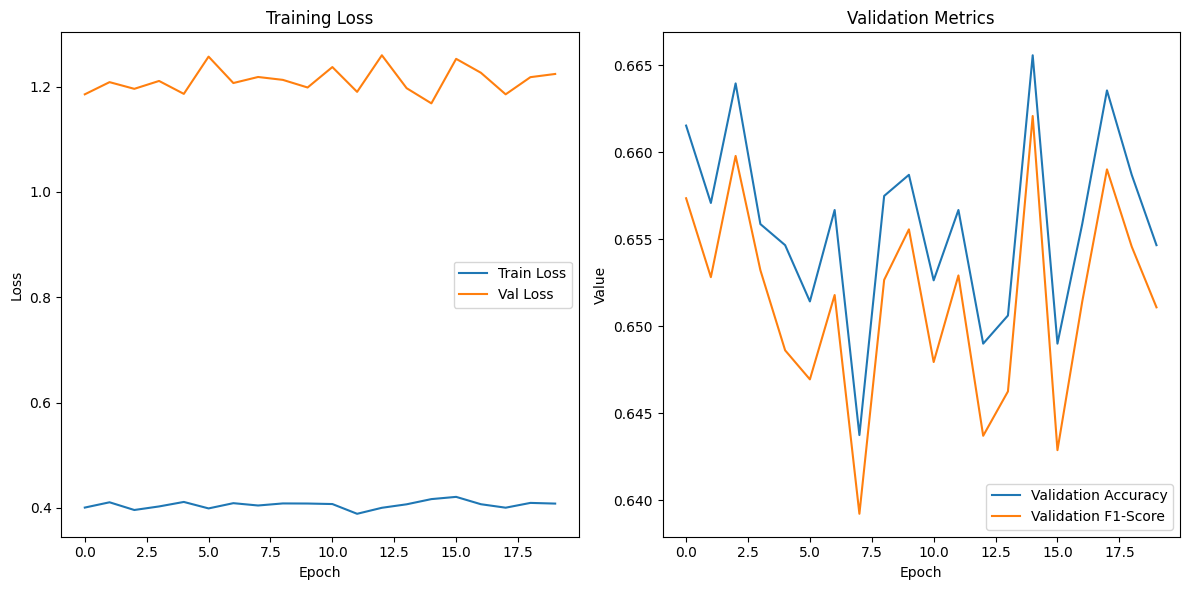

In [36]:
visualize_model_results(rain_losses_pipeline1, val_losses_pipeline1, val_metrics_pipeline1, epochs=20)

In [37]:
# После обучения производим предсказания и сохраняем их в требуемый формат
output_file = "test_predictions__75_pipeline1.csv"
predict_and_save(vgg, test_loader, output_file) 

100%|██████████| 166/166 [00:51<00:00,  3.19it/s]

Предсказания сохранены в файл test_predictions__75_pipeline1.csv


In [48]:
# torch.save(vgg, 'final_vgg_pipeline1_75')

In [65]:
train_losses_pipeline2, val_losses_pipeline2, val_metrics_pipeline2 = train_and_evaluate(
    vgg, criterion, optimizer, train_loader2, val_loader2, num_epochs=75, lr=lr)

Epoch 1/75 [Validation]: 100%|██████████| 78/78 [00:25<00:00,  3.11it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/75, Train Loss: 2.5922, Val Loss: 2.5445, Val Acc: 0.2078, Val Prec: 0.1099, Val Recall: 0.2078, Val F1: 0.1153


Epoch 2/75 [Validation]: 100%|██████████| 78/78 [00:25<00:00,  3.07it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 2/75, Train Loss: 2.5621, Val Loss: 2.4611, Val Acc: 0.2212, Val Prec: 0.1216, Val Recall: 0.2212, Val F1: 0.0962


Epoch 3/75 [Validation]: 100%|██████████| 78/78 [00:27<00:00,  2.79it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 3/75, Train Loss: 2.5071, Val Loss: 2.4123, Val Acc: 0.2519, Val Prec: 0.1216, Val Recall: 0.2519, Val F1: 0.1511


Epoch 4/75 [Validation]: 100%|██████████| 78/78 [00:25<00:00,  3.10it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 4/75, Train Loss: 2.4697, Val Loss: 2.4284, Val Acc: 0.2082, Val Prec: 0.1151, Val Recall: 0.2082, Val F1: 0.1086


Epoch 5/75 [Validation]: 100%|██████████| 78/78 [00:24<00:00,  3.13it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 5/75, Train Loss: 2.4559, Val Loss: 2.3655, Val Acc: 0.2511, Val Prec: 0.1587, Val Recall: 0.2511, Val F1: 0.1576


Epoch 6/75 [Validation]: 100%|██████████| 78/78 [00:24<00:00,  3.15it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 6/75, Train Loss: 2.4303, Val Loss: 2.3444, Val Acc: 0.2697, Val Prec: 0.1607, Val Recall: 0.2697, Val F1: 0.1750


Epoch 7/75 [Validation]: 100%|██████████| 78/78 [00:24<00:00,  3.15it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 7/75, Train Loss: 2.4202, Val Loss: 2.3239, Val Acc: 0.2511, Val Prec: 0.1444, Val Recall: 0.2511, Val F1: 0.1568


Epoch 8/75 [Validation]: 100%|██████████| 78/78 [00:24<00:00,  3.14it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 8/75, Train Loss: 2.4016, Val Loss: 2.2998, Val Acc: 0.2560, Val Prec: 0.1825, Val Recall: 0.2560, Val F1: 0.1712


Epoch 9/75 [Validation]: 100%|██████████| 78/78 [00:25<00:00,  3.05it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 9/75, Train Loss: 2.3924, Val Loss: 2.3235, Val Acc: 0.2653, Val Prec: 0.1888, Val Recall: 0.2653, Val F1: 0.1560


Epoch 10/75 [Validation]: 100%|██████████| 78/78 [00:24<00:00,  3.12it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 10/75, Train Loss: 2.3908, Val Loss: 2.2859, Val Acc: 0.2685, Val Prec: 0.1862, Val Recall: 0.2685, Val F1: 0.1723


Epoch 11/75 [Validation]: 100%|██████████| 78/78 [00:24<00:00,  3.13it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 11/75, Train Loss: 2.3486, Val Loss: 2.2747, Val Acc: 0.2758, Val Prec: 0.2286, Val Recall: 0.2758, Val F1: 0.1814


Epoch 12/75 [Validation]: 100%|██████████| 78/78 [00:24<00:00,  3.19it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 12/75, Train Loss: 2.3411, Val Loss: 2.2782, Val Acc: 0.2685, Val Prec: 0.1959, Val Recall: 0.2685, Val F1: 0.1740


Epoch 13/75 [Validation]: 100%|██████████| 78/78 [00:24<00:00,  3.15it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 13/75, Train Loss: 2.3351, Val Loss: 2.2750, Val Acc: 0.2790, Val Prec: 0.2481, Val Recall: 0.2790, Val F1: 0.1836


Epoch 14/75 [Validation]: 100%|██████████| 78/78 [00:25<00:00,  3.11it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 14/75, Train Loss: 2.3338, Val Loss: 2.2720, Val Acc: 0.2786, Val Prec: 0.2447, Val Recall: 0.2786, Val F1: 0.1792


Epoch 15/75 [Validation]: 100%|██████████| 78/78 [00:27<00:00,  2.79it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 15/75, Train Loss: 2.3041, Val Loss: 2.2407, Val Acc: 0.2863, Val Prec: 0.2723, Val Recall: 0.2863, Val F1: 0.1978


Epoch 16/75 [Validation]: 100%|██████████| 78/78 [00:27<00:00,  2.82it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 16/75, Train Loss: 2.2915, Val Loss: 2.2164, Val Acc: 0.2968, Val Prec: 0.2441, Val Recall: 0.2968, Val F1: 0.2082


Epoch 17/75 [Validation]: 100%|██████████| 78/78 [00:24<00:00,  3.14it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 17/75, Train Loss: 2.2657, Val Loss: 2.2179, Val Acc: 0.2932, Val Prec: 0.2124, Val Recall: 0.2932, Val F1: 0.2083


Epoch 18/75 [Validation]: 100%|██████████| 78/78 [00:25<00:00,  3.09it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 18/75, Train Loss: 2.2489, Val Loss: 2.1734, Val Acc: 0.3110, Val Prec: 0.2530, Val Recall: 0.3110, Val F1: 0.2436


Epoch 19/75 [Validation]: 100%|██████████| 78/78 [00:25<00:00,  3.01it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 19/75, Train Loss: 2.2244, Val Loss: 2.1362, Val Acc: 0.3190, Val Prec: 0.2950, Val Recall: 0.3190, Val F1: 0.2381


Epoch 20/75 [Validation]: 100%|██████████| 78/78 [00:24<00:00,  3.19it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 20/75, Train Loss: 2.1928, Val Loss: 2.1076, Val Acc: 0.3312, Val Prec: 0.3437, Val Recall: 0.3312, Val F1: 0.2544


Epoch 21/75 [Validation]: 100%|██████████| 78/78 [00:28<00:00,  2.73it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 21/75, Train Loss: 2.1831, Val Loss: 2.1263, Val Acc: 0.3190, Val Prec: 0.2898, Val Recall: 0.3190, Val F1: 0.2418


Epoch 22/75 [Validation]: 100%|██████████| 78/78 [00:27<00:00,  2.83it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 22/75, Train Loss: 2.1609, Val Loss: 2.0815, Val Acc: 0.3441, Val Prec: 0.3625, Val Recall: 0.3441, Val F1: 0.2704


Epoch 23/75 [Validation]: 100%|██████████| 78/78 [00:25<00:00,  3.12it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 23/75, Train Loss: 2.1333, Val Loss: 2.0863, Val Acc: 0.3405, Val Prec: 0.3174, Val Recall: 0.3405, Val F1: 0.2824


Epoch 24/75 [Validation]: 100%|██████████| 78/78 [00:25<00:00,  3.09it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 24/75, Train Loss: 2.1058, Val Loss: 2.0784, Val Acc: 0.3465, Val Prec: 0.3234, Val Recall: 0.3465, Val F1: 0.2938


Epoch 25/75 [Validation]: 100%|██████████| 78/78 [00:24<00:00,  3.13it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 25/75, Train Loss: 2.0857, Val Loss: 2.0514, Val Acc: 0.3518, Val Prec: 0.3851, Val Recall: 0.3518, Val F1: 0.2941


Epoch 26/75 [Validation]: 100%|██████████| 78/78 [00:28<00:00,  2.75it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 26/75, Train Loss: 2.0701, Val Loss: 2.0584, Val Acc: 0.3429, Val Prec: 0.3337, Val Recall: 0.3429, Val F1: 0.2812


Epoch 27/75 [Validation]: 100%|██████████| 78/78 [00:30<00:00,  2.56it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 27/75, Train Loss: 2.0441, Val Loss: 2.0000, Val Acc: 0.3607, Val Prec: 0.3562, Val Recall: 0.3607, Val F1: 0.2937


Epoch 28/75 [Validation]: 100%|██████████| 78/78 [00:24<00:00,  3.18it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 28/75, Train Loss: 2.0183, Val Loss: 1.9600, Val Acc: 0.3753, Val Prec: 0.3702, Val Recall: 0.3753, Val F1: 0.3326


Epoch 29/75 [Validation]: 100%|██████████| 78/78 [00:24<00:00,  3.14it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 29/75, Train Loss: 2.0100, Val Loss: 1.9661, Val Acc: 0.3611, Val Prec: 0.3570, Val Recall: 0.3611, Val F1: 0.3099


Epoch 30/75 [Validation]: 100%|██████████| 78/78 [00:24<00:00,  3.21it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 30/75, Train Loss: 1.9719, Val Loss: 1.9275, Val Acc: 0.3785, Val Prec: 0.3969, Val Recall: 0.3785, Val F1: 0.3269


Epoch 31/75 [Validation]: 100%|██████████| 78/78 [00:29<00:00,  2.66it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 31/75, Train Loss: 1.9736, Val Loss: 1.9422, Val Acc: 0.3858, Val Prec: 0.3818, Val Recall: 0.3858, Val F1: 0.3471


Epoch 32/75 [Validation]: 100%|██████████| 78/78 [00:28<00:00,  2.74it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 32/75, Train Loss: 1.9278, Val Loss: 1.9058, Val Acc: 0.3939, Val Prec: 0.3859, Val Recall: 0.3939, Val F1: 0.3464


Epoch 33/75 [Validation]: 100%|██████████| 78/78 [00:24<00:00,  3.22it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 33/75, Train Loss: 1.9173, Val Loss: 1.8859, Val Acc: 0.3967, Val Prec: 0.4058, Val Recall: 0.3967, Val F1: 0.3591


Epoch 34/75 [Validation]: 100%|██████████| 78/78 [00:29<00:00,  2.62it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 34/75, Train Loss: 1.8996, Val Loss: 1.8723, Val Acc: 0.4027, Val Prec: 0.4454, Val Recall: 0.4027, Val F1: 0.3582


Epoch 35/75 [Validation]: 100%|██████████| 78/78 [00:27<00:00,  2.81it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 35/75, Train Loss: 1.8810, Val Loss: 1.8776, Val Acc: 0.3930, Val Prec: 0.4305, Val Recall: 0.3930, Val F1: 0.3494


Epoch 36/75 [Validation]: 100%|██████████| 78/78 [00:30<00:00,  2.56it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 36/75, Train Loss: 1.8568, Val Loss: 1.8564, Val Acc: 0.4157, Val Prec: 0.4118, Val Recall: 0.4157, Val F1: 0.3696


Epoch 37/75 [Validation]: 100%|██████████| 78/78 [00:24<00:00,  3.18it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 37/75, Train Loss: 1.8261, Val Loss: 1.8551, Val Acc: 0.4096, Val Prec: 0.4211, Val Recall: 0.4096, Val F1: 0.3662


Epoch 38/75 [Validation]: 100%|██████████| 78/78 [00:24<00:00,  3.19it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 38/75, Train Loss: 1.8089, Val Loss: 1.7876, Val Acc: 0.4238, Val Prec: 0.5200, Val Recall: 0.4238, Val F1: 0.3863


Epoch 39/75 [Validation]: 100%|██████████| 78/78 [00:24<00:00,  3.22it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 39/75, Train Loss: 1.7857, Val Loss: 1.7988, Val Acc: 0.4205, Val Prec: 0.4895, Val Recall: 0.4205, Val F1: 0.3842


Epoch 40/75 [Validation]: 100%|██████████| 78/78 [00:24<00:00,  3.20it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 40/75, Train Loss: 1.7784, Val Loss: 1.7745, Val Acc: 0.4311, Val Prec: 0.5277, Val Recall: 0.4311, Val F1: 0.4012


Epoch 41/75 [Validation]: 100%|██████████| 78/78 [00:24<00:00,  3.21it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 41/75, Train Loss: 1.7382, Val Loss: 1.7740, Val Acc: 0.4218, Val Prec: 0.4738, Val Recall: 0.4218, Val F1: 0.3978


Epoch 42/75 [Validation]: 100%|██████████| 78/78 [00:24<00:00,  3.21it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 42/75, Train Loss: 1.7067, Val Loss: 1.7541, Val Acc: 0.4408, Val Prec: 0.5075, Val Recall: 0.4408, Val F1: 0.4049


Epoch 43/75 [Validation]: 100%|██████████| 78/78 [00:24<00:00,  3.22it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 43/75, Train Loss: 1.6936, Val Loss: 1.7263, Val Acc: 0.4400, Val Prec: 0.5222, Val Recall: 0.4400, Val F1: 0.4093


Epoch 44/75 [Validation]: 100%|██████████| 78/78 [00:24<00:00,  3.22it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 44/75, Train Loss: 1.6622, Val Loss: 1.7239, Val Acc: 0.4581, Val Prec: 0.5127, Val Recall: 0.4581, Val F1: 0.4267


Epoch 45/75 [Validation]: 100%|██████████| 78/78 [00:24<00:00,  3.22it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 45/75, Train Loss: 1.6444, Val Loss: 1.7150, Val Acc: 0.4545, Val Prec: 0.4831, Val Recall: 0.4545, Val F1: 0.4321


Epoch 46/75 [Validation]: 100%|██████████| 78/78 [00:24<00:00,  3.22it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 46/75, Train Loss: 1.6201, Val Loss: 1.6864, Val Acc: 0.4666, Val Prec: 0.5596, Val Recall: 0.4666, Val F1: 0.4404


Epoch 47/75 [Validation]: 100%|██████████| 78/78 [00:24<00:00,  3.21it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 47/75, Train Loss: 1.6160, Val Loss: 1.6658, Val Acc: 0.4654, Val Prec: 0.5291, Val Recall: 0.4654, Val F1: 0.4377


Epoch 48/75 [Validation]: 100%|██████████| 78/78 [00:24<00:00,  3.20it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 48/75, Train Loss: 1.5714, Val Loss: 1.6888, Val Acc: 0.4618, Val Prec: 0.4858, Val Recall: 0.4618, Val F1: 0.4305


Epoch 49/75 [Validation]: 100%|██████████| 78/78 [00:24<00:00,  3.23it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 49/75, Train Loss: 1.5669, Val Loss: 1.6619, Val Acc: 0.4650, Val Prec: 0.5170, Val Recall: 0.4650, Val F1: 0.4380


Epoch 50/75 [Validation]: 100%|██████████| 78/78 [00:24<00:00,  3.21it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 50/75, Train Loss: 1.5291, Val Loss: 1.6339, Val Acc: 0.4808, Val Prec: 0.5397, Val Recall: 0.4808, Val F1: 0.4636


Epoch 51/75 [Validation]: 100%|██████████| 78/78 [00:24<00:00,  3.20it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 51/75, Train Loss: 1.5136, Val Loss: 1.6080, Val Acc: 0.4840, Val Prec: 0.5405, Val Recall: 0.4840, Val F1: 0.4595


Epoch 52/75 [Validation]: 100%|██████████| 78/78 [00:30<00:00,  2.59it/s]


Epoch 52/75, Train Loss: 1.4891, Val Loss: 1.6346, Val Acc: 0.4848, Val Prec: 0.5114, Val Recall: 0.4848, Val F1: 0.4603


Epoch 53/75 [Validation]: 100%|██████████| 78/78 [00:27<00:00,  2.82it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 53/75, Train Loss: 1.4829, Val Loss: 1.6383, Val Acc: 0.4731, Val Prec: 0.5338, Val Recall: 0.4731, Val F1: 0.4538


Epoch 54/75 [Validation]: 100%|██████████| 78/78 [00:29<00:00,  2.69it/s]


Epoch 54/75, Train Loss: 1.4589, Val Loss: 1.6159, Val Acc: 0.4917, Val Prec: 0.5326, Val Recall: 0.4917, Val F1: 0.4670


Epoch 55/75 [Validation]: 100%|██████████| 78/78 [00:27<00:00,  2.86it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 55/75, Train Loss: 1.4388, Val Loss: 1.5937, Val Acc: 0.4982, Val Prec: 0.5605, Val Recall: 0.4982, Val F1: 0.4775


Epoch 56/75 [Validation]: 100%|██████████| 78/78 [00:30<00:00,  2.59it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 56/75, Train Loss: 1.4191, Val Loss: 1.6570, Val Acc: 0.4780, Val Prec: 0.5245, Val Recall: 0.4780, Val F1: 0.4593


Epoch 57/75 [Validation]: 100%|██████████| 78/78 [00:27<00:00,  2.85it/s]


Epoch 57/75, Train Loss: 1.4009, Val Loss: 1.5739, Val Acc: 0.5042, Val Prec: 0.5183, Val Recall: 0.5042, Val F1: 0.4843


Epoch 58/75 [Validation]: 100%|██████████| 78/78 [00:30<00:00,  2.57it/s]


Epoch 58/75, Train Loss: 1.3519, Val Loss: 1.5861, Val Acc: 0.5055, Val Prec: 0.5282, Val Recall: 0.5055, Val F1: 0.4820


Epoch 59/75 [Validation]: 100%|██████████| 78/78 [00:28<00:00,  2.75it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 59/75, Train Loss: 1.3592, Val Loss: 1.5641, Val Acc: 0.5042, Val Prec: 0.5465, Val Recall: 0.5042, Val F1: 0.4859


Epoch 60/75 [Validation]: 100%|██████████| 78/78 [00:24<00:00,  3.14it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 60/75, Train Loss: 1.3284, Val Loss: 1.5484, Val Acc: 0.5253, Val Prec: 0.5490, Val Recall: 0.5253, Val F1: 0.5051


Epoch 61/75 [Validation]: 100%|██████████| 78/78 [00:28<00:00,  2.70it/s]


Epoch 61/75, Train Loss: 1.3284, Val Loss: 1.5674, Val Acc: 0.5087, Val Prec: 0.5245, Val Recall: 0.5087, Val F1: 0.4864


Epoch 62/75 [Validation]: 100%|██████████| 78/78 [00:29<00:00,  2.65it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 62/75, Train Loss: 1.3360, Val Loss: 1.5701, Val Acc: 0.5131, Val Prec: 0.5716, Val Recall: 0.5131, Val F1: 0.4998


Epoch 63/75 [Validation]: 100%|██████████| 78/78 [00:29<00:00,  2.63it/s]


Epoch 63/75, Train Loss: 1.2798, Val Loss: 1.5568, Val Acc: 0.5220, Val Prec: 0.5447, Val Recall: 0.5220, Val F1: 0.5037


Epoch 64/75 [Validation]: 100%|██████████| 78/78 [00:28<00:00,  2.72it/s]


Epoch 64/75, Train Loss: 1.2602, Val Loss: 1.5668, Val Acc: 0.5103, Val Prec: 0.5347, Val Recall: 0.5103, Val F1: 0.4914


Epoch 65/75 [Validation]: 100%|██████████| 78/78 [00:24<00:00,  3.21it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 65/75, Train Loss: 1.2538, Val Loss: 1.5271, Val Acc: 0.5180, Val Prec: 0.5559, Val Recall: 0.5180, Val F1: 0.5047


Epoch 66/75 [Validation]: 100%|██████████| 78/78 [00:23<00:00,  3.26it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 66/75, Train Loss: 1.2250, Val Loss: 1.5342, Val Acc: 0.5249, Val Prec: 0.5474, Val Recall: 0.5249, Val F1: 0.5135


Epoch 67/75 [Validation]: 100%|██████████| 78/78 [00:24<00:00,  3.25it/s]


Epoch 67/75, Train Loss: 1.2101, Val Loss: 1.5399, Val Acc: 0.5289, Val Prec: 0.5587, Val Recall: 0.5289, Val F1: 0.5100


Epoch 68/75 [Validation]: 100%|██████████| 78/78 [00:24<00:00,  3.25it/s]


Epoch 68/75, Train Loss: 1.1981, Val Loss: 1.5097, Val Acc: 0.5370, Val Prec: 0.5644, Val Recall: 0.5370, Val F1: 0.5225


Epoch 69/75 [Validation]: 100%|██████████| 78/78 [00:23<00:00,  3.25it/s]


Epoch 69/75, Train Loss: 1.1821, Val Loss: 1.5127, Val Acc: 0.5358, Val Prec: 0.5771, Val Recall: 0.5358, Val F1: 0.5225


Epoch 70/75 [Validation]: 100%|██████████| 78/78 [00:24<00:00,  3.24it/s]


Epoch 70/75, Train Loss: 1.1816, Val Loss: 1.5318, Val Acc: 0.5350, Val Prec: 0.5483, Val Recall: 0.5350, Val F1: 0.5206


Epoch 71/75 [Validation]: 100%|██████████| 78/78 [00:24<00:00,  3.24it/s]


Epoch 71/75, Train Loss: 1.1901, Val Loss: 1.5169, Val Acc: 0.5253, Val Prec: 0.5511, Val Recall: 0.5253, Val F1: 0.5138


Epoch 72/75 [Validation]: 100%|██████████| 78/78 [00:24<00:00,  3.24it/s]


Epoch 72/75, Train Loss: 1.1593, Val Loss: 1.5312, Val Acc: 0.5350, Val Prec: 0.5576, Val Recall: 0.5350, Val F1: 0.5222


Epoch 73/75 [Validation]: 100%|██████████| 78/78 [00:24<00:00,  3.25it/s]


Epoch 73/75, Train Loss: 1.1347, Val Loss: 1.5384, Val Acc: 0.5309, Val Prec: 0.5745, Val Recall: 0.5309, Val F1: 0.5183


Epoch 74/75 [Validation]: 100%|██████████| 78/78 [00:24<00:00,  3.25it/s]


Epoch 74/75, Train Loss: 1.1238, Val Loss: 1.5398, Val Acc: 0.5354, Val Prec: 0.5518, Val Recall: 0.5354, Val F1: 0.5214


Epoch 75/75 [Validation]: 100%|██████████| 78/78 [00:24<00:00,  3.23it/s]

Epoch 75/75, Train Loss: 1.0805, Val Loss: 1.4726, Val Acc: 0.5467, Val Prec: 0.5851, Val Recall: 0.5467, Val F1: 0.5386


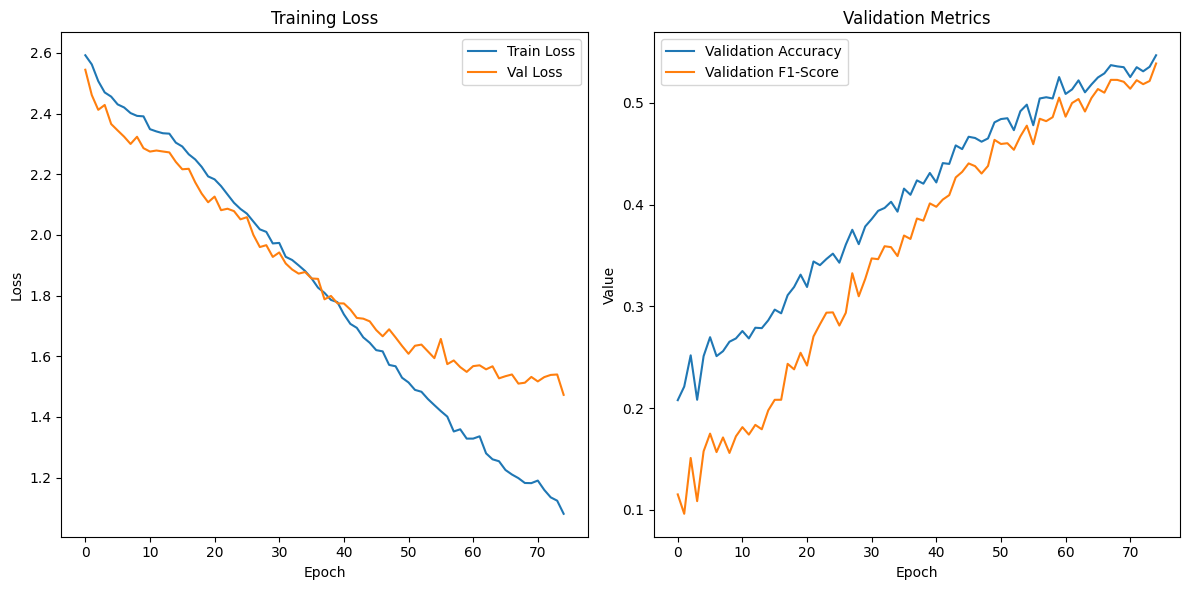

In [67]:
visualize_model_results(train_losses_pipeline2, val_losses_pipeline2, val_metrics_pipeline2, epochs=75)

In [68]:
# После обучения производим предсказания и сохраняем их в требуемый формат
output_file = "test_predictions__75_pipeline2.csv"
predict_and_save(vgg, test_loader, output_file) 

100%|██████████| 166/166 [01:23<00:00,  1.98it/s]

Предсказания сохранены в файл test_predictions__75_pipeline2.csv


In [106]:
# Другой пайплайн, смесь с train_transform

train_losses_pipeline5, val_losses_pipeline5, val_metrics_pipeline5 = train_and_evaluate(
    vgg, criterion, optimizer, train_loader5, val_loader5, num_epochs=75, lr=lr)

c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
Epoch 1/75 [Validation]: 100%|██████████| 78/78 [00:54<00:00,  1.44it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/75, Train Loss: 2.6992, Val Loss: 2.4946, Val Acc: 0.2208, Val Prec: 0.1408, Val Recall: 0.2208, Val F1: 0.1612


Epoch 2/75 [Validation]: 100%|██████████| 78/78 [00:35<00:00,  2.21it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 2/75, Train Loss: 2.5238, Val Loss: 2.4374, Val Acc: 0.2228, Val Prec: 0.1621, Val Recall: 0.2228, Val F1: 0.1457


Epoch 3/75 [Validation]: 100%|██████████| 78/78 [00:34<00:00,  2.29it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 3/75, Train Loss: 2.4802, Val Loss: 2.3974, Val Acc: 0.2220, Val Prec: 0.1633, Val Recall: 0.2220, Val F1: 0.1343


Epoch 4/75 [Validation]: 100%|██████████| 78/78 [00:34<00:00,  2.25it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 4/75, Train Loss: 2.4604, Val Loss: 2.3885, Val Acc: 0.2430, Val Prec: 0.1951, Val Recall: 0.2430, Val F1: 0.1557


Epoch 5/75 [Validation]: 100%|██████████| 78/78 [00:34<00:00,  2.25it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 5/75, Train Loss: 2.4129, Val Loss: 2.3140, Val Acc: 0.2754, Val Prec: 0.2194, Val Recall: 0.2754, Val F1: 0.1927


Epoch 6/75 [Validation]: 100%|██████████| 78/78 [00:33<00:00,  2.34it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 6/75, Train Loss: 2.3862, Val Loss: 2.3425, Val Acc: 0.2624, Val Prec: 0.1432, Val Recall: 0.2624, Val F1: 0.1693


Epoch 7/75 [Validation]: 100%|██████████| 78/78 [00:34<00:00,  2.29it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 7/75, Train Loss: 2.3850, Val Loss: 2.3331, Val Acc: 0.2588, Val Prec: 0.1808, Val Recall: 0.2588, Val F1: 0.1665


Epoch 8/75 [Validation]: 100%|██████████| 78/78 [00:33<00:00,  2.31it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 8/75, Train Loss: 2.3542, Val Loss: 2.3569, Val Acc: 0.2572, Val Prec: 0.2100, Val Recall: 0.2572, Val F1: 0.1763


Epoch 9/75 [Validation]: 100%|██████████| 78/78 [00:33<00:00,  2.30it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 9/75, Train Loss: 2.3421, Val Loss: 2.2649, Val Acc: 0.2705, Val Prec: 0.2133, Val Recall: 0.2705, Val F1: 0.1689


Epoch 10/75 [Validation]: 100%|██████████| 78/78 [00:34<00:00,  2.29it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 10/75, Train Loss: 2.3144, Val Loss: 2.2359, Val Acc: 0.2843, Val Prec: 0.2865, Val Recall: 0.2843, Val F1: 0.1966


Epoch 11/75 [Validation]: 100%|██████████| 78/78 [00:33<00:00,  2.30it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 11/75, Train Loss: 2.2952, Val Loss: 2.2445, Val Acc: 0.2790, Val Prec: 0.2505, Val Recall: 0.2790, Val F1: 0.1841


Epoch 12/75 [Validation]: 100%|██████████| 78/78 [00:33<00:00,  2.32it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 12/75, Train Loss: 2.2842, Val Loss: 2.2138, Val Acc: 0.2867, Val Prec: 0.2024, Val Recall: 0.2867, Val F1: 0.1974


Epoch 13/75 [Validation]: 100%|██████████| 78/78 [00:32<00:00,  2.37it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 13/75, Train Loss: 2.2656, Val Loss: 2.1835, Val Acc: 0.2899, Val Prec: 0.3265, Val Recall: 0.2899, Val F1: 0.2029


Epoch 14/75 [Validation]: 100%|██████████| 78/78 [00:37<00:00,  2.07it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 14/75, Train Loss: 2.2504, Val Loss: 2.1962, Val Acc: 0.2976, Val Prec: 0.2570, Val Recall: 0.2976, Val F1: 0.2200


Epoch 15/75 [Validation]: 100%|██████████| 78/78 [00:36<00:00,  2.11it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 15/75, Train Loss: 2.2201, Val Loss: 2.1651, Val Acc: 0.3069, Val Prec: 0.2761, Val Recall: 0.3069, Val F1: 0.2363


Epoch 16/75 [Validation]: 100%|██████████| 78/78 [00:36<00:00,  2.14it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 16/75, Train Loss: 2.2017, Val Loss: 2.1793, Val Acc: 0.3037, Val Prec: 0.3079, Val Recall: 0.3037, Val F1: 0.2230


Epoch 17/75 [Validation]: 100%|██████████| 78/78 [00:50<00:00,  1.55it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 17/75, Train Loss: 2.1664, Val Loss: 2.1360, Val Acc: 0.3093, Val Prec: 0.2882, Val Recall: 0.3093, Val F1: 0.2458


Epoch 18/75 [Validation]: 100%|██████████| 78/78 [00:40<00:00,  1.93it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 18/75, Train Loss: 2.1533, Val Loss: 2.1121, Val Acc: 0.3247, Val Prec: 0.3140, Val Recall: 0.3247, Val F1: 0.2554


Epoch 19/75 [Validation]: 100%|██████████| 78/78 [00:35<00:00,  2.18it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 19/75, Train Loss: 2.1355, Val Loss: 2.0833, Val Acc: 0.3308, Val Prec: 0.3537, Val Recall: 0.3308, Val F1: 0.2648


Epoch 20/75 [Validation]: 100%|██████████| 78/78 [00:35<00:00,  2.20it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 20/75, Train Loss: 2.1192, Val Loss: 2.1043, Val Acc: 0.3292, Val Prec: 0.3310, Val Recall: 0.3292, Val F1: 0.2789


Epoch 21/75 [Validation]: 100%|██████████| 78/78 [00:39<00:00,  1.97it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 21/75, Train Loss: 2.0940, Val Loss: 2.0280, Val Acc: 0.3465, Val Prec: 0.3842, Val Recall: 0.3465, Val F1: 0.2838


Epoch 22/75 [Validation]: 100%|██████████| 78/78 [00:35<00:00,  2.21it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 22/75, Train Loss: 2.0571, Val Loss: 2.0321, Val Acc: 0.3409, Val Prec: 0.3591, Val Recall: 0.3409, Val F1: 0.2875


Epoch 23/75 [Validation]: 100%|██████████| 78/78 [00:35<00:00,  2.20it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 23/75, Train Loss: 2.0327, Val Loss: 2.0073, Val Acc: 0.3498, Val Prec: 0.3107, Val Recall: 0.3498, Val F1: 0.2934


Epoch 24/75 [Validation]: 100%|██████████| 78/78 [00:38<00:00,  2.03it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 24/75, Train Loss: 2.0210, Val Loss: 1.9958, Val Acc: 0.3660, Val Prec: 0.3938, Val Recall: 0.3660, Val F1: 0.3170


Epoch 25/75 [Validation]: 100%|██████████| 78/78 [00:40<00:00,  1.94it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 25/75, Train Loss: 1.9983, Val Loss: 1.9582, Val Acc: 0.3740, Val Prec: 0.3753, Val Recall: 0.3740, Val F1: 0.3286


Epoch 26/75 [Validation]: 100%|██████████| 78/78 [00:39<00:00,  2.00it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 26/75, Train Loss: 1.9688, Val Loss: 1.9620, Val Acc: 0.3716, Val Prec: 0.4183, Val Recall: 0.3716, Val F1: 0.3201


Epoch 27/75 [Validation]: 100%|██████████| 78/78 [00:39<00:00,  1.98it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 27/75, Train Loss: 1.9419, Val Loss: 1.9157, Val Acc: 0.3821, Val Prec: 0.4130, Val Recall: 0.3821, Val F1: 0.3453


Epoch 28/75 [Validation]: 100%|██████████| 78/78 [00:39<00:00,  1.99it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 28/75, Train Loss: 1.9300, Val Loss: 1.9097, Val Acc: 0.3797, Val Prec: 0.3936, Val Recall: 0.3797, Val F1: 0.3376


Epoch 29/75 [Validation]: 100%|██████████| 78/78 [00:39<00:00,  1.96it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 29/75, Train Loss: 1.8959, Val Loss: 1.9016, Val Acc: 0.3854, Val Prec: 0.4132, Val Recall: 0.3854, Val F1: 0.3535


Epoch 30/75 [Validation]: 100%|██████████| 78/78 [00:39<00:00,  1.99it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 30/75, Train Loss: 1.8669, Val Loss: 1.8919, Val Acc: 0.3955, Val Prec: 0.4829, Val Recall: 0.3955, Val F1: 0.3540


Epoch 31/75 [Validation]: 100%|██████████| 78/78 [00:38<00:00,  2.02it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 31/75, Train Loss: 1.8632, Val Loss: 1.8797, Val Acc: 0.4027, Val Prec: 0.4658, Val Recall: 0.4027, Val F1: 0.3698


Epoch 32/75 [Validation]: 100%|██████████| 78/78 [00:37<00:00,  2.06it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 32/75, Train Loss: 1.8261, Val Loss: 1.8366, Val Acc: 0.4108, Val Prec: 0.4405, Val Recall: 0.4108, Val F1: 0.3732


Epoch 33/75 [Validation]: 100%|██████████| 78/78 [00:38<00:00,  2.02it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 33/75, Train Loss: 1.7994, Val Loss: 1.8271, Val Acc: 0.4080, Val Prec: 0.4601, Val Recall: 0.4080, Val F1: 0.3742


Epoch 34/75 [Validation]: 100%|██████████| 78/78 [00:38<00:00,  2.04it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 34/75, Train Loss: 1.7551, Val Loss: 1.7957, Val Acc: 0.4311, Val Prec: 0.4757, Val Recall: 0.4311, Val F1: 0.3995


Epoch 35/75 [Validation]: 100%|██████████| 78/78 [00:38<00:00,  2.04it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 35/75, Train Loss: 1.7488, Val Loss: 1.7914, Val Acc: 0.4238, Val Prec: 0.4796, Val Recall: 0.4238, Val F1: 0.3932


Epoch 36/75 [Validation]: 100%|██████████| 78/78 [00:37<00:00,  2.11it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 36/75, Train Loss: 1.7158, Val Loss: 1.7897, Val Acc: 0.4319, Val Prec: 0.4757, Val Recall: 0.4319, Val F1: 0.3984


Epoch 37/75 [Validation]: 100%|██████████| 78/78 [00:37<00:00,  2.11it/s]


Epoch 37/75, Train Loss: 1.7002, Val Loss: 1.7631, Val Acc: 0.4476, Val Prec: 0.4623, Val Recall: 0.4476, Val F1: 0.4208


Epoch 38/75 [Validation]: 100%|██████████| 78/78 [00:37<00:00,  2.07it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 38/75, Train Loss: 1.6840, Val Loss: 1.7526, Val Acc: 0.4391, Val Prec: 0.4799, Val Recall: 0.4391, Val F1: 0.4085


Epoch 39/75 [Validation]: 100%|██████████| 78/78 [00:37<00:00,  2.06it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 39/75, Train Loss: 1.6582, Val Loss: 1.7488, Val Acc: 0.4428, Val Prec: 0.4720, Val Recall: 0.4428, Val F1: 0.4173


Epoch 40/75 [Validation]: 100%|██████████| 78/78 [00:33<00:00,  2.31it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 40/75, Train Loss: 1.6352, Val Loss: 1.7232, Val Acc: 0.4497, Val Prec: 0.5391, Val Recall: 0.4497, Val F1: 0.4216


Epoch 41/75 [Validation]: 100%|██████████| 78/78 [00:36<00:00,  2.12it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 41/75, Train Loss: 1.6068, Val Loss: 1.7115, Val Acc: 0.4517, Val Prec: 0.5030, Val Recall: 0.4517, Val F1: 0.4253


Epoch 42/75 [Validation]: 100%|██████████| 78/78 [00:36<00:00,  2.11it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 42/75, Train Loss: 1.5985, Val Loss: 1.6570, Val Acc: 0.4772, Val Prec: 0.4938, Val Recall: 0.4772, Val F1: 0.4513


Epoch 43/75 [Validation]: 100%|██████████| 78/78 [00:37<00:00,  2.10it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 43/75, Train Loss: 1.5721, Val Loss: 1.6637, Val Acc: 0.4727, Val Prec: 0.4978, Val Recall: 0.4727, Val F1: 0.4485


Epoch 44/75 [Validation]: 100%|██████████| 78/78 [00:37<00:00,  2.08it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 44/75, Train Loss: 1.5503, Val Loss: 1.6835, Val Acc: 0.4666, Val Prec: 0.5283, Val Recall: 0.4666, Val F1: 0.4468


Epoch 45/75 [Validation]: 100%|██████████| 78/78 [00:36<00:00,  2.11it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 45/75, Train Loss: 1.5209, Val Loss: 1.6533, Val Acc: 0.4767, Val Prec: 0.5221, Val Recall: 0.4767, Val F1: 0.4512


Epoch 46/75 [Validation]: 100%|██████████| 78/78 [00:42<00:00,  1.84it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 46/75, Train Loss: 1.4981, Val Loss: 1.6568, Val Acc: 0.4731, Val Prec: 0.5227, Val Recall: 0.4731, Val F1: 0.4515


Epoch 47/75 [Validation]: 100%|██████████| 78/78 [00:41<00:00,  1.88it/s]


Epoch 47/75, Train Loss: 1.4975, Val Loss: 1.6288, Val Acc: 0.4812, Val Prec: 0.5007, Val Recall: 0.4812, Val F1: 0.4604


Epoch 48/75 [Validation]: 100%|██████████| 78/78 [00:40<00:00,  1.93it/s]


Epoch 48/75, Train Loss: 1.4700, Val Loss: 1.6012, Val Acc: 0.5010, Val Prec: 0.5260, Val Recall: 0.5010, Val F1: 0.4793


Epoch 49/75 [Validation]: 100%|██████████| 78/78 [00:42<00:00,  1.82it/s]


Epoch 49/75, Train Loss: 1.4445, Val Loss: 1.5931, Val Acc: 0.5018, Val Prec: 0.5378, Val Recall: 0.5018, Val F1: 0.4844


Epoch 50/75 [Validation]: 100%|██████████| 78/78 [00:42<00:00,  1.82it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 50/75, Train Loss: 1.4169, Val Loss: 1.5741, Val Acc: 0.5038, Val Prec: 0.5179, Val Recall: 0.5038, Val F1: 0.4811


Epoch 51/75 [Validation]: 100%|██████████| 78/78 [00:40<00:00,  1.94it/s]


Epoch 51/75, Train Loss: 1.4150, Val Loss: 1.5748, Val Acc: 0.4998, Val Prec: 0.5374, Val Recall: 0.4998, Val F1: 0.4868


Epoch 52/75 [Validation]: 100%|██████████| 78/78 [00:42<00:00,  1.85it/s]


Epoch 52/75, Train Loss: 1.3887, Val Loss: 1.5832, Val Acc: 0.5026, Val Prec: 0.5228, Val Recall: 0.5026, Val F1: 0.4874


Epoch 53/75 [Validation]: 100%|██████████| 78/78 [00:41<00:00,  1.90it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 53/75, Train Loss: 1.3769, Val Loss: 1.5915, Val Acc: 0.5083, Val Prec: 0.5386, Val Recall: 0.5083, Val F1: 0.4890


Epoch 54/75 [Validation]: 100%|██████████| 78/78 [00:35<00:00,  2.19it/s]


Epoch 54/75, Train Loss: 1.3686, Val Loss: 1.5713, Val Acc: 0.5188, Val Prec: 0.5252, Val Recall: 0.5188, Val F1: 0.4972


Epoch 55/75 [Validation]: 100%|██████████| 78/78 [00:35<00:00,  2.22it/s]


Epoch 55/75, Train Loss: 1.3511, Val Loss: 1.5481, Val Acc: 0.5224, Val Prec: 0.5510, Val Recall: 0.5224, Val F1: 0.5031


Epoch 56/75 [Validation]: 100%|██████████| 78/78 [00:46<00:00,  1.69it/s]


Epoch 56/75, Train Loss: 1.3407, Val Loss: 1.5513, Val Acc: 0.5123, Val Prec: 0.5577, Val Recall: 0.5123, Val F1: 0.4937


Epoch 57/75 [Validation]: 100%|██████████| 78/78 [00:44<00:00,  1.75it/s]


Epoch 57/75, Train Loss: 1.3193, Val Loss: 1.5473, Val Acc: 0.5160, Val Prec: 0.5521, Val Recall: 0.5160, Val F1: 0.4990


Epoch 58/75 [Validation]: 100%|██████████| 78/78 [00:39<00:00,  1.99it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 58/75, Train Loss: 1.2874, Val Loss: 1.5801, Val Acc: 0.5131, Val Prec: 0.5291, Val Recall: 0.5131, Val F1: 0.4973


Epoch 59/75 [Validation]: 100%|██████████| 78/78 [00:34<00:00,  2.27it/s]


Epoch 59/75, Train Loss: 1.2960, Val Loss: 1.5121, Val Acc: 0.5293, Val Prec: 0.5559, Val Recall: 0.5293, Val F1: 0.5173


Epoch 60/75 [Validation]: 100%|██████████| 78/78 [00:35<00:00,  2.21it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 60/75, Train Loss: 1.2735, Val Loss: 1.5206, Val Acc: 0.5313, Val Prec: 0.5389, Val Recall: 0.5313, Val F1: 0.5139


Epoch 61/75 [Validation]: 100%|██████████| 78/78 [00:43<00:00,  1.79it/s]


Epoch 61/75, Train Loss: 1.2690, Val Loss: 1.4986, Val Acc: 0.5338, Val Prec: 0.5496, Val Recall: 0.5338, Val F1: 0.5243


Epoch 62/75 [Validation]: 100%|██████████| 78/78 [00:42<00:00,  1.82it/s]


Epoch 62/75, Train Loss: 1.2390, Val Loss: 1.5378, Val Acc: 0.5334, Val Prec: 0.5755, Val Recall: 0.5334, Val F1: 0.5189


Epoch 63/75 [Validation]: 100%|██████████| 78/78 [00:35<00:00,  2.20it/s]


Epoch 63/75, Train Loss: 1.2259, Val Loss: 1.4834, Val Acc: 0.5402, Val Prec: 0.5666, Val Recall: 0.5402, Val F1: 0.5257


Epoch 64/75 [Validation]: 100%|██████████| 78/78 [00:35<00:00,  2.21it/s]


Epoch 64/75, Train Loss: 1.2066, Val Loss: 1.4752, Val Acc: 0.5463, Val Prec: 0.5571, Val Recall: 0.5463, Val F1: 0.5296


Epoch 65/75 [Validation]: 100%|██████████| 78/78 [00:35<00:00,  2.22it/s]


Epoch 65/75, Train Loss: 1.2123, Val Loss: 1.5127, Val Acc: 0.5358, Val Prec: 0.5700, Val Recall: 0.5358, Val F1: 0.5240


Epoch 66/75 [Validation]: 100%|██████████| 78/78 [00:35<00:00,  2.20it/s]


Epoch 66/75, Train Loss: 1.1839, Val Loss: 1.5006, Val Acc: 0.5431, Val Prec: 0.5684, Val Recall: 0.5431, Val F1: 0.5320


Epoch 67/75 [Validation]: 100%|██████████| 78/78 [00:36<00:00,  2.11it/s]


Epoch 67/75, Train Loss: 1.1919, Val Loss: 1.4806, Val Acc: 0.5410, Val Prec: 0.5797, Val Recall: 0.5410, Val F1: 0.5260


Epoch 68/75 [Validation]: 100%|██████████| 78/78 [00:35<00:00,  2.21it/s]


Epoch 68/75, Train Loss: 1.1732, Val Loss: 1.4892, Val Acc: 0.5406, Val Prec: 0.5646, Val Recall: 0.5406, Val F1: 0.5272


Epoch 69/75 [Validation]: 100%|██████████| 78/78 [00:34<00:00,  2.27it/s]


Epoch 69/75, Train Loss: 1.1440, Val Loss: 1.4923, Val Acc: 0.5354, Val Prec: 0.5695, Val Recall: 0.5354, Val F1: 0.5230


Epoch 70/75 [Validation]: 100%|██████████| 78/78 [00:34<00:00,  2.28it/s]


Epoch 70/75, Train Loss: 1.1451, Val Loss: 1.4449, Val Acc: 0.5548, Val Prec: 0.5648, Val Recall: 0.5548, Val F1: 0.5381


Epoch 71/75 [Validation]: 100%|██████████| 78/78 [00:33<00:00,  2.33it/s]


Epoch 71/75, Train Loss: 1.1291, Val Loss: 1.4742, Val Acc: 0.5431, Val Prec: 0.5714, Val Recall: 0.5431, Val F1: 0.5340


Epoch 72/75 [Validation]: 100%|██████████| 78/78 [00:34<00:00,  2.27it/s]


Epoch 72/75, Train Loss: 1.1376, Val Loss: 1.4814, Val Acc: 0.5443, Val Prec: 0.5808, Val Recall: 0.5443, Val F1: 0.5320


Epoch 73/75 [Validation]: 100%|██████████| 78/78 [00:34<00:00,  2.26it/s]


Epoch 73/75, Train Loss: 1.1024, Val Loss: 1.4486, Val Acc: 0.5528, Val Prec: 0.5801, Val Recall: 0.5528, Val F1: 0.5400


Epoch 74/75 [Validation]: 100%|██████████| 78/78 [00:34<00:00,  2.28it/s]


Epoch 74/75, Train Loss: 1.0841, Val Loss: 1.4761, Val Acc: 0.5516, Val Prec: 0.5936, Val Recall: 0.5516, Val F1: 0.5416


Epoch 75/75 [Validation]: 100%|██████████| 78/78 [00:34<00:00,  2.28it/s]


Epoch 75/75, Train Loss: 1.0745, Val Loss: 1.4327, Val Acc: 0.5544, Val Prec: 0.5695, Val Recall: 0.5544, Val F1: 0.5422


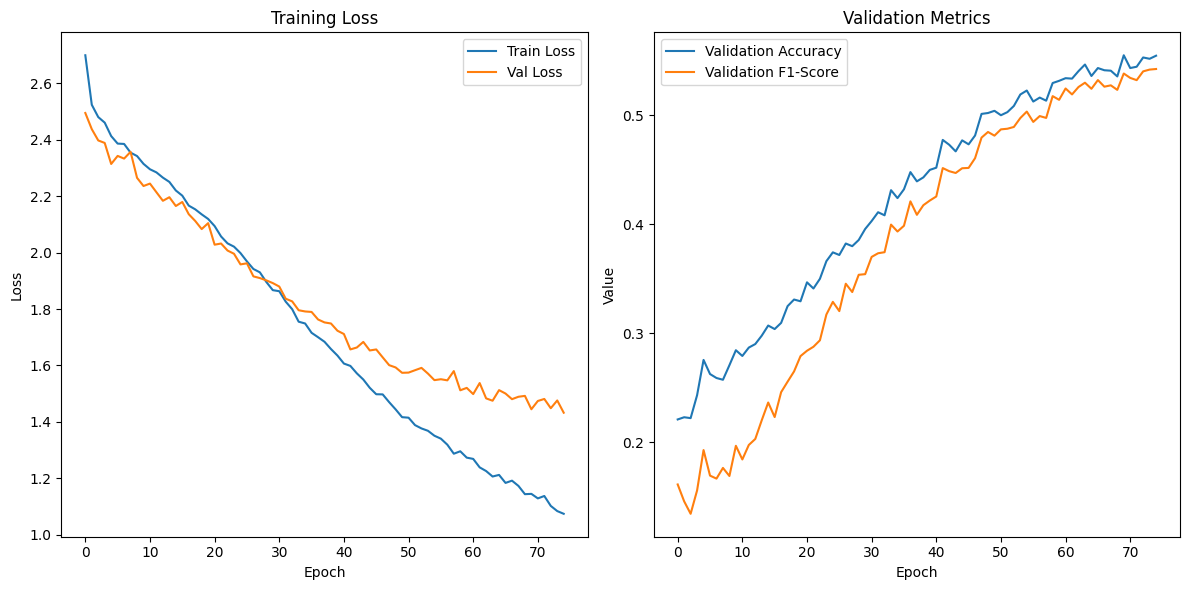

In [107]:
visualize_model_results(train_losses_pipeline5, val_losses_pipeline5, val_metrics_pipeline5, epochs=75)

In [109]:
torch.save(vgg.state_dict(), 'vgg_pipeline5_75_epochs.pth')

In [108]:
# После обучения производим предсказания и сохраняем их в требуемый формат
output_file = "test_predictions__75_pipeline5.csv"
predict_and_save(vgg, test_loader, output_file) 

100%|██████████| 166/166 [01:38<00:00,  1.68it/s]

Предсказания сохранены в файл test_predictions__75_pipeline5.csv


In [112]:
vgg = ImprovedVGG(num_classes=num_classes + 1).to(device)

c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
Epoch 1/75 [Validation]: 100%|██████████| 78/78 [00:43<00:00,  1.80it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/75, Train Loss: 2.9922, Val Loss: 2.9603, Val Acc: 0.0930, Val Prec: 0.0998, Val Recall: 0.0930, Val F1: 0.0394


Epoch 2/75 [Validation]: 100%|██████████| 78/78 [00:41<00:00,  1.89it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 2/75, Train Loss: 2.9861, Val Loss: 2.9617, Val Acc: 0.0950, Val Prec: 0.2554, Val Recall: 0.0950, Val F1: 0.0462


Epoch 3/75 [Validation]: 100%|██████████| 78/78 [00:40<00:00,  1.93it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 3/75, Train Loss: 2.9925, Val Loss: 2.9602, Val Acc: 0.0906, Val Prec: 0.0334, Val Recall: 0.0906, Val F1: 0.0381


Epoch 4/75 [Validation]: 100%|██████████| 78/78 [00:46<00:00,  1.68it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 4/75, Train Loss: 2.9920, Val Loss: 2.9617, Val Acc: 0.0930, Val Prec: 0.0351, Val Recall: 0.0930, Val F1: 0.0393


Epoch 5/75 [Validation]: 100%|██████████| 78/78 [00:38<00:00,  2.03it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 5/75, Train Loss: 2.9914, Val Loss: 2.9638, Val Acc: 0.0906, Val Prec: 0.0352, Val Recall: 0.0906, Val F1: 0.0400


Epoch 6/75 [Validation]: 100%|██████████| 78/78 [00:36<00:00,  2.11it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 6/75, Train Loss: 2.9911, Val Loss: 2.9608, Val Acc: 0.0934, Val Prec: 0.0443, Val Recall: 0.0934, Val F1: 0.0401


Epoch 7/75 [Validation]: 100%|██████████| 78/78 [00:43<00:00,  1.80it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 7/75, Train Loss: 2.9876, Val Loss: 2.9587, Val Acc: 0.0910, Val Prec: 0.0341, Val Recall: 0.0910, Val F1: 0.0389


Epoch 8/75 [Validation]: 100%|██████████| 78/78 [00:37<00:00,  2.09it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 8/75, Train Loss: 2.9878, Val Loss: 2.9637, Val Acc: 0.0882, Val Prec: 0.0457, Val Recall: 0.0882, Val F1: 0.0384


Epoch 9/75 [Validation]: 100%|██████████| 78/78 [00:36<00:00,  2.16it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 9/75, Train Loss: 2.9917, Val Loss: 2.9633, Val Acc: 0.0894, Val Prec: 0.1951, Val Recall: 0.0894, Val F1: 0.0393


Epoch 10/75 [Validation]: 100%|██████████| 78/78 [00:36<00:00,  2.13it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 10/75, Train Loss: 2.9885, Val Loss: 2.9625, Val Acc: 0.0894, Val Prec: 0.0476, Val Recall: 0.0894, Val F1: 0.0404


Epoch 11/75 [Validation]: 100%|██████████| 78/78 [00:36<00:00,  2.16it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 11/75, Train Loss: 2.9882, Val Loss: 2.9628, Val Acc: 0.0906, Val Prec: 0.1094, Val Recall: 0.0906, Val F1: 0.0420


Epoch 12/75 [Training]:  70%|██████▉   | 216/310 [01:55<00:50,  1.87it/s]


Training was interrupted. Residual visualization of passed epochs: 


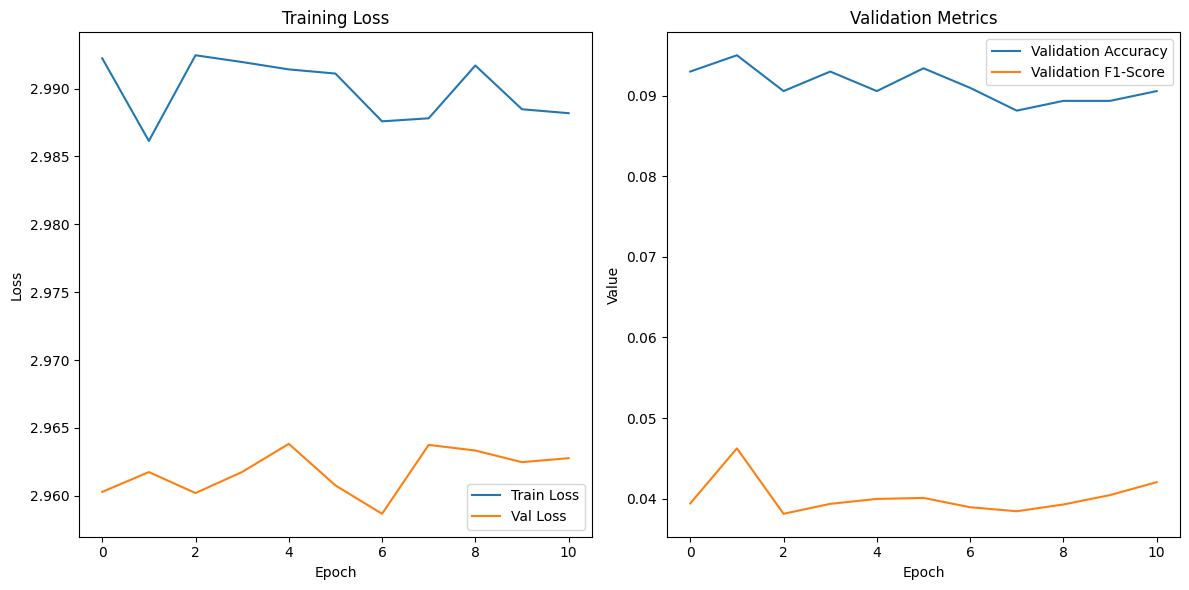

In [113]:
# Другой пайплайн6, смесь с train_transform

train_losses_pipeline6, val_losses_pipeline6, val_metrics_pipeline6 = train_and_evaluate(
    vgg, criterion, optimizer, train_loader6, val_loader6, num_epochs=75, lr=lr)

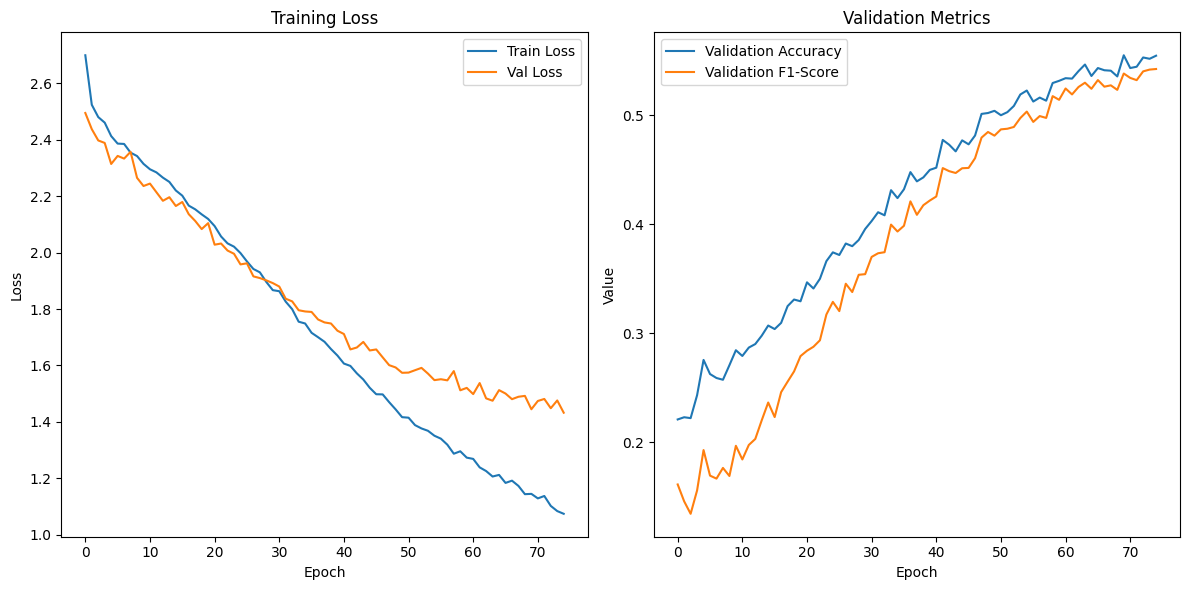

In [ ]:
visualize_model_results(train_losses_pipeline6, val_losses_pipeline6, val_metrics_pipeline6, epochs=75)

In [ ]:
torch.save(vgg.state_dict(), 'vgg_pipeline6_75_epochs.pth')

In [ ]:
# После обучения производим предсказания и сохраняем их в требуемый формат
output_file = "test_predictions__75_pipeline6.csv"
predict_and_save(vgg, test_loader, output_file) 

100%|██████████| 166/166 [01:38<00:00,  1.68it/s]

Предсказания сохранены в файл test_predictions__75_pipeline5.csv


In [ ]:
vgg = ImprovedVGG(num_classes=num_classes + 1).to(device)

In [121]:
# Другой пайплайн6, смесь с train_transform

train_losses_pipeline4, val_losses_pipeline4, val_metrics_pipeline4 = train_and_evaluate(
    vgg, criterion, optimizer, train_loader4, val_loader4, num_epochs=75, lr=lr)

c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
Epoch 1/75 [Validation]: 100%|██████████| 78/78 [00:35<00:00,  2.18it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/75, Train Loss: 2.9627, Val Loss: 2.9352, Val Acc: 0.0566, Val Prec: 0.1186, Val Recall: 0.0566, Val F1: 0.0434


Epoch 2/75 [Validation]: 100%|██████████| 78/78 [00:35<00:00,  2.22it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 2/75, Train Loss: 2.9650, Val Loss: 2.9356, Val Acc: 0.0441, Val Prec: 0.1763, Val Recall: 0.0441, Val F1: 0.0394


Epoch 3/75 [Validation]: 100%|██████████| 78/78 [00:35<00:00,  2.22it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 3/75, Train Loss: 2.9588, Val Loss: 2.9337, Val Acc: 0.0493, Val Prec: 0.1457, Val Recall: 0.0493, Val F1: 0.0406


Epoch 4/75 [Validation]: 100%|██████████| 78/78 [00:35<00:00,  2.19it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 4/75, Train Loss: 2.9619, Val Loss: 2.9352, Val Acc: 0.0461, Val Prec: 0.0750, Val Recall: 0.0461, Val F1: 0.0332


Epoch 5/75 [Validation]: 100%|██████████| 78/78 [00:35<00:00,  2.22it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 5/75, Train Loss: 2.9647, Val Loss: 2.9360, Val Acc: 0.0469, Val Prec: 0.1139, Val Recall: 0.0469, Val F1: 0.0358


Epoch 6/75 [Validation]: 100%|██████████| 78/78 [00:36<00:00,  2.15it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 6/75, Train Loss: 2.9608, Val Loss: 2.9367, Val Acc: 0.0412, Val Prec: 0.0907, Val Recall: 0.0412, Val F1: 0.0323


Epoch 7/75 [Validation]: 100%|██████████| 78/78 [00:35<00:00,  2.22it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 7/75, Train Loss: 2.9658, Val Loss: 2.9392, Val Acc: 0.0485, Val Prec: 0.0838, Val Recall: 0.0485, Val F1: 0.0360


Epoch 8/75 [Validation]: 100%|██████████| 78/78 [00:35<00:00,  2.21it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 8/75, Train Loss: 2.9614, Val Loss: 2.9365, Val Acc: 0.0489, Val Prec: 0.0937, Val Recall: 0.0489, Val F1: 0.0387


Epoch 9/75 [Validation]: 100%|██████████| 78/78 [00:35<00:00,  2.20it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 9/75, Train Loss: 2.9609, Val Loss: 2.9360, Val Acc: 0.0437, Val Prec: 0.1814, Val Recall: 0.0437, Val F1: 0.0363


Epoch 10/75 [Validation]: 100%|██████████| 78/78 [00:35<00:00,  2.18it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 10/75, Train Loss: 2.9632, Val Loss: 2.9387, Val Acc: 0.0412, Val Prec: 0.0825, Val Recall: 0.0412, Val F1: 0.0337


Epoch 11/75 [Validation]: 100%|██████████| 78/78 [00:35<00:00,  2.18it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 11/75, Train Loss: 2.9587, Val Loss: 2.9381, Val Acc: 0.0493, Val Prec: 0.0743, Val Recall: 0.0493, Val F1: 0.0342


Epoch 12/75 [Validation]: 100%|██████████| 78/78 [00:35<00:00,  2.21it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 12/75, Train Loss: 2.9620, Val Loss: 2.9356, Val Acc: 0.0469, Val Prec: 0.0718, Val Recall: 0.0469, Val F1: 0.0342


Epoch 13/75 [Validation]: 100%|██████████| 78/78 [00:35<00:00,  2.20it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 13/75, Train Loss: 2.9603, Val Loss: 2.9395, Val Acc: 0.0477, Val Prec: 0.0870, Val Recall: 0.0477, Val F1: 0.0378


Epoch 14/75 [Validation]: 100%|██████████| 78/78 [00:35<00:00,  2.23it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 14/75, Train Loss: 2.9638, Val Loss: 2.9328, Val Acc: 0.0477, Val Prec: 0.0819, Val Recall: 0.0477, Val F1: 0.0358


Epoch 15/75 [Validation]: 100%|██████████| 78/78 [00:35<00:00,  2.17it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 15/75, Train Loss: 2.9613, Val Loss: 2.9359, Val Acc: 0.0384, Val Prec: 0.0612, Val Recall: 0.0384, Val F1: 0.0279


Epoch 16/75 [Validation]: 100%|██████████| 78/78 [00:35<00:00,  2.21it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 16/75, Train Loss: 2.9585, Val Loss: 2.9384, Val Acc: 0.0497, Val Prec: 0.0951, Val Recall: 0.0497, Val F1: 0.0391


Epoch 17/75 [Validation]: 100%|██████████| 78/78 [00:34<00:00,  2.24it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 17/75, Train Loss: 2.9610, Val Loss: 2.9360, Val Acc: 0.0433, Val Prec: 0.0806, Val Recall: 0.0433, Val F1: 0.0328


Epoch 18/75 [Validation]: 100%|██████████| 78/78 [00:35<00:00,  2.22it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 18/75, Train Loss: 2.9668, Val Loss: 2.9387, Val Acc: 0.0501, Val Prec: 0.0483, Val Recall: 0.0501, Val F1: 0.0341


Epoch 19/75 [Validation]: 100%|██████████| 78/78 [00:34<00:00,  2.26it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 19/75, Train Loss: 2.9640, Val Loss: 2.9352, Val Acc: 0.0522, Val Prec: 0.0815, Val Recall: 0.0522, Val F1: 0.0405


Epoch 20/75 [Validation]: 100%|██████████| 78/78 [00:34<00:00,  2.25it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 20/75, Train Loss: 2.9633, Val Loss: 2.9379, Val Acc: 0.0437, Val Prec: 0.0728, Val Recall: 0.0437, Val F1: 0.0326


Epoch 21/75 [Validation]: 100%|██████████| 78/78 [00:34<00:00,  2.24it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 21/75, Train Loss: 2.9610, Val Loss: 2.9370, Val Acc: 0.0477, Val Prec: 0.0919, Val Recall: 0.0477, Val F1: 0.0420


Epoch 22/75 [Validation]: 100%|██████████| 78/78 [00:35<00:00,  2.19it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 22/75, Train Loss: 2.9597, Val Loss: 2.9365, Val Acc: 0.0510, Val Prec: 0.0632, Val Recall: 0.0510, Val F1: 0.0351


Epoch 23/75 [Validation]: 100%|██████████| 78/78 [00:35<00:00,  2.22it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 23/75, Train Loss: 2.9649, Val Loss: 2.9346, Val Acc: 0.0534, Val Prec: 0.1165, Val Recall: 0.0534, Val F1: 0.0452


Epoch 24/75 [Validation]: 100%|██████████| 78/78 [00:34<00:00,  2.24it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 24/75, Train Loss: 2.9614, Val Loss: 2.9377, Val Acc: 0.0473, Val Prec: 0.0795, Val Recall: 0.0473, Val F1: 0.0362


Epoch 25/75 [Validation]: 100%|██████████| 78/78 [00:35<00:00,  2.19it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 25/75, Train Loss: 2.9605, Val Loss: 2.9382, Val Acc: 0.0421, Val Prec: 0.0743, Val Recall: 0.0421, Val F1: 0.0344


Epoch 26/75 [Validation]: 100%|██████████| 78/78 [00:34<00:00,  2.25it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 26/75, Train Loss: 2.9630, Val Loss: 2.9403, Val Acc: 0.0412, Val Prec: 0.0939, Val Recall: 0.0412, Val F1: 0.0333


Epoch 27/75 [Validation]: 100%|██████████| 78/78 [00:34<00:00,  2.23it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 27/75, Train Loss: 2.9614, Val Loss: 2.9385, Val Acc: 0.0396, Val Prec: 0.0566, Val Recall: 0.0396, Val F1: 0.0306


Epoch 28/75 [Validation]: 100%|██████████| 78/78 [00:35<00:00,  2.20it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 28/75, Train Loss: 2.9649, Val Loss: 2.9357, Val Acc: 0.0380, Val Prec: 0.0739, Val Recall: 0.0380, Val F1: 0.0270


Epoch 29/75 [Validation]: 100%|██████████| 78/78 [00:34<00:00,  2.25it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 29/75, Train Loss: 2.9601, Val Loss: 2.9385, Val Acc: 0.0473, Val Prec: 0.0903, Val Recall: 0.0473, Val F1: 0.0391


Epoch 30/75 [Validation]: 100%|██████████| 78/78 [00:35<00:00,  2.19it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 30/75, Train Loss: 2.9598, Val Loss: 2.9347, Val Acc: 0.0534, Val Prec: 0.0793, Val Recall: 0.0534, Val F1: 0.0398


Epoch 31/75 [Validation]: 100%|██████████| 78/78 [00:35<00:00,  2.20it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 31/75, Train Loss: 2.9604, Val Loss: 2.9374, Val Acc: 0.0421, Val Prec: 0.1088, Val Recall: 0.0421, Val F1: 0.0321


Epoch 32/75 [Validation]: 100%|██████████| 78/78 [00:35<00:00,  2.18it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 32/75, Train Loss: 2.9612, Val Loss: 2.9367, Val Acc: 0.0408, Val Prec: 0.0675, Val Recall: 0.0408, Val F1: 0.0318


Epoch 33/75 [Validation]: 100%|██████████| 78/78 [00:35<00:00,  2.21it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 33/75, Train Loss: 2.9643, Val Loss: 2.9362, Val Acc: 0.0453, Val Prec: 0.0816, Val Recall: 0.0453, Val F1: 0.0346


Epoch 34/75 [Validation]: 100%|██████████| 78/78 [00:36<00:00,  2.15it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 34/75, Train Loss: 2.9619, Val Loss: 2.9354, Val Acc: 0.0425, Val Prec: 0.0949, Val Recall: 0.0425, Val F1: 0.0349


Epoch 35/75 [Validation]: 100%|██████████| 78/78 [00:34<00:00,  2.24it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 35/75, Train Loss: 2.9589, Val Loss: 2.9390, Val Acc: 0.0437, Val Prec: 0.0967, Val Recall: 0.0437, Val F1: 0.0377


Epoch 36/75 [Validation]: 100%|██████████| 78/78 [00:35<00:00,  2.19it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 36/75, Train Loss: 2.9603, Val Loss: 2.9369, Val Acc: 0.0404, Val Prec: 0.0655, Val Recall: 0.0404, Val F1: 0.0293


Epoch 37/75 [Validation]: 100%|██████████| 78/78 [00:35<00:00,  2.19it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 37/75, Train Loss: 2.9615, Val Loss: 2.9380, Val Acc: 0.0429, Val Prec: 0.0847, Val Recall: 0.0429, Val F1: 0.0332


Epoch 38/75 [Validation]: 100%|██████████| 78/78 [00:34<00:00,  2.24it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 38/75, Train Loss: 2.9596, Val Loss: 2.9392, Val Acc: 0.0388, Val Prec: 0.0802, Val Recall: 0.0388, Val F1: 0.0306


Epoch 39/75 [Validation]: 100%|██████████| 78/78 [00:35<00:00,  2.22it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 39/75, Train Loss: 2.9632, Val Loss: 2.9360, Val Acc: 0.0437, Val Prec: 0.0823, Val Recall: 0.0437, Val F1: 0.0383


Epoch 40/75 [Validation]: 100%|██████████| 78/78 [00:35<00:00,  2.18it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 40/75, Train Loss: 2.9636, Val Loss: 2.9371, Val Acc: 0.0392, Val Prec: 0.0787, Val Recall: 0.0392, Val F1: 0.0302


Epoch 41/75 [Validation]: 100%|██████████| 78/78 [00:34<00:00,  2.24it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 41/75, Train Loss: 2.9674, Val Loss: 2.9367, Val Acc: 0.0445, Val Prec: 0.0920, Val Recall: 0.0445, Val F1: 0.0360


Epoch 42/75 [Validation]: 100%|██████████| 78/78 [00:34<00:00,  2.24it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 42/75, Train Loss: 2.9635, Val Loss: 2.9339, Val Acc: 0.0481, Val Prec: 0.0789, Val Recall: 0.0481, Val F1: 0.0349


Epoch 43/75 [Validation]: 100%|██████████| 78/78 [00:35<00:00,  2.18it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 43/75, Train Loss: 2.9635, Val Loss: 2.9386, Val Acc: 0.0449, Val Prec: 0.1269, Val Recall: 0.0449, Val F1: 0.0372


Epoch 44/75 [Validation]: 100%|██████████| 78/78 [00:34<00:00,  2.24it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 44/75, Train Loss: 2.9605, Val Loss: 2.9421, Val Acc: 0.0433, Val Prec: 0.0976, Val Recall: 0.0433, Val F1: 0.0337


Epoch 45/75 [Validation]: 100%|██████████| 78/78 [00:35<00:00,  2.20it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 45/75, Train Loss: 2.9610, Val Loss: 2.9372, Val Acc: 0.0501, Val Prec: 0.1701, Val Recall: 0.0501, Val F1: 0.0437


Epoch 46/75 [Validation]: 100%|██████████| 78/78 [00:35<00:00,  2.23it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 46/75, Train Loss: 2.9626, Val Loss: 2.9387, Val Acc: 0.0433, Val Prec: 0.1616, Val Recall: 0.0433, Val F1: 0.0377


Epoch 47/75 [Validation]: 100%|██████████| 78/78 [00:35<00:00,  2.23it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 47/75, Train Loss: 2.9616, Val Loss: 2.9362, Val Acc: 0.0489, Val Prec: 0.1324, Val Recall: 0.0489, Val F1: 0.0409


Epoch 48/75 [Validation]: 100%|██████████| 78/78 [00:34<00:00,  2.23it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 48/75, Train Loss: 2.9640, Val Loss: 2.9377, Val Acc: 0.0449, Val Prec: 0.1199, Val Recall: 0.0449, Val F1: 0.0360


Epoch 49/75 [Validation]: 100%|██████████| 78/78 [00:35<00:00,  2.22it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 49/75, Train Loss: 2.9595, Val Loss: 2.9383, Val Acc: 0.0421, Val Prec: 0.0628, Val Recall: 0.0421, Val F1: 0.0321


Epoch 50/75 [Validation]: 100%|██████████| 78/78 [00:35<00:00,  2.22it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 50/75, Train Loss: 2.9608, Val Loss: 2.9377, Val Acc: 0.0421, Val Prec: 0.0709, Val Recall: 0.0421, Val F1: 0.0291


Epoch 51/75 [Validation]: 100%|██████████| 78/78 [00:35<00:00,  2.22it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 51/75, Train Loss: 2.9636, Val Loss: 2.9371, Val Acc: 0.0457, Val Prec: 0.0778, Val Recall: 0.0457, Val F1: 0.0340


Epoch 52/75 [Validation]: 100%|██████████| 78/78 [00:34<00:00,  2.25it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 52/75, Train Loss: 2.9650, Val Loss: 2.9377, Val Acc: 0.0408, Val Prec: 0.0806, Val Recall: 0.0408, Val F1: 0.0307


Epoch 53/75 [Validation]: 100%|██████████| 78/78 [00:35<00:00,  2.19it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 53/75, Train Loss: 2.9631, Val Loss: 2.9379, Val Acc: 0.0356, Val Prec: 0.0643, Val Recall: 0.0356, Val F1: 0.0276


Epoch 54/75 [Validation]: 100%|██████████| 78/78 [00:35<00:00,  2.22it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 54/75, Train Loss: 2.9667, Val Loss: 2.9379, Val Acc: 0.0421, Val Prec: 0.0492, Val Recall: 0.0421, Val F1: 0.0295


Epoch 55/75 [Validation]: 100%|██████████| 78/78 [00:36<00:00,  2.15it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 55/75, Train Loss: 2.9627, Val Loss: 2.9361, Val Acc: 0.0522, Val Prec: 0.0995, Val Recall: 0.0522, Val F1: 0.0414


Epoch 56/75 [Validation]: 100%|██████████| 78/78 [00:35<00:00,  2.22it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 56/75, Train Loss: 2.9649, Val Loss: 2.9382, Val Acc: 0.0408, Val Prec: 0.0696, Val Recall: 0.0408, Val F1: 0.0295


Epoch 57/75 [Validation]: 100%|██████████| 78/78 [00:35<00:00,  2.20it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 57/75, Train Loss: 2.9628, Val Loss: 2.9395, Val Acc: 0.0457, Val Prec: 0.0944, Val Recall: 0.0457, Val F1: 0.0384


Epoch 58/75 [Validation]: 100%|██████████| 78/78 [00:33<00:00,  2.30it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 58/75, Train Loss: 2.9613, Val Loss: 2.9342, Val Acc: 0.0400, Val Prec: 0.1260, Val Recall: 0.0400, Val F1: 0.0323


Epoch 59/75 [Validation]: 100%|██████████| 78/78 [00:35<00:00,  2.23it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 59/75, Train Loss: 2.9645, Val Loss: 2.9368, Val Acc: 0.0469, Val Prec: 0.0713, Val Recall: 0.0469, Val F1: 0.0336


Epoch 60/75 [Validation]: 100%|██████████| 78/78 [00:35<00:00,  2.19it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 60/75, Train Loss: 2.9619, Val Loss: 2.9341, Val Acc: 0.0538, Val Prec: 0.1016, Val Recall: 0.0538, Val F1: 0.0410


Epoch 61/75 [Validation]: 100%|██████████| 78/78 [00:35<00:00,  2.20it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 61/75, Train Loss: 2.9606, Val Loss: 2.9383, Val Acc: 0.0416, Val Prec: 0.0786, Val Recall: 0.0416, Val F1: 0.0312


Epoch 62/75 [Validation]: 100%|██████████| 78/78 [00:35<00:00,  2.22it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 62/75, Train Loss: 2.9656, Val Loss: 2.9381, Val Acc: 0.0445, Val Prec: 0.0788, Val Recall: 0.0445, Val F1: 0.0342


Epoch 63/75 [Validation]: 100%|██████████| 78/78 [00:35<00:00,  2.22it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 63/75, Train Loss: 2.9623, Val Loss: 2.9384, Val Acc: 0.0457, Val Prec: 0.0828, Val Recall: 0.0457, Val F1: 0.0356


Epoch 64/75 [Validation]: 100%|██████████| 78/78 [00:34<00:00,  2.23it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 64/75, Train Loss: 2.9641, Val Loss: 2.9341, Val Acc: 0.0461, Val Prec: 0.0930, Val Recall: 0.0461, Val F1: 0.0351


Epoch 65/75 [Validation]: 100%|██████████| 78/78 [00:35<00:00,  2.19it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 65/75, Train Loss: 2.9627, Val Loss: 2.9398, Val Acc: 0.0396, Val Prec: 0.0649, Val Recall: 0.0396, Val F1: 0.0301


Epoch 66/75 [Validation]: 100%|██████████| 78/78 [00:34<00:00,  2.23it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 66/75, Train Loss: 2.9639, Val Loss: 2.9386, Val Acc: 0.0425, Val Prec: 0.0714, Val Recall: 0.0425, Val F1: 0.0325


Epoch 67/75 [Validation]: 100%|██████████| 78/78 [00:34<00:00,  2.23it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 67/75, Train Loss: 2.9602, Val Loss: 2.9366, Val Acc: 0.0400, Val Prec: 0.0972, Val Recall: 0.0400, Val F1: 0.0359


Epoch 68/75 [Validation]: 100%|██████████| 78/78 [00:34<00:00,  2.24it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 68/75, Train Loss: 2.9643, Val Loss: 2.9369, Val Acc: 0.0433, Val Prec: 0.0938, Val Recall: 0.0433, Val F1: 0.0332


Epoch 69/75 [Validation]: 100%|██████████| 78/78 [00:48<00:00,  1.59it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 69/75, Train Loss: 2.9620, Val Loss: 2.9375, Val Acc: 0.0388, Val Prec: 0.0672, Val Recall: 0.0388, Val F1: 0.0303


Epoch 70/75 [Validation]: 100%|██████████| 78/78 [00:35<00:00,  2.21it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 70/75, Train Loss: 2.9647, Val Loss: 2.9389, Val Acc: 0.0416, Val Prec: 0.0794, Val Recall: 0.0416, Val F1: 0.0328


Epoch 71/75 [Validation]: 100%|██████████| 78/78 [00:35<00:00,  2.21it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 71/75, Train Loss: 2.9632, Val Loss: 2.9383, Val Acc: 0.0445, Val Prec: 0.0446, Val Recall: 0.0445, Val F1: 0.0303


Epoch 72/75 [Validation]: 100%|██████████| 78/78 [00:35<00:00,  2.20it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 72/75, Train Loss: 2.9610, Val Loss: 2.9378, Val Acc: 0.0441, Val Prec: 0.0785, Val Recall: 0.0441, Val F1: 0.0317


Epoch 73/75 [Validation]: 100%|██████████| 78/78 [00:35<00:00,  2.22it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 73/75, Train Loss: 2.9622, Val Loss: 2.9401, Val Acc: 0.0416, Val Prec: 0.0792, Val Recall: 0.0416, Val F1: 0.0344


Epoch 74/75 [Validation]: 100%|██████████| 78/78 [00:35<00:00,  2.20it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 74/75, Train Loss: 2.9605, Val Loss: 2.9342, Val Acc: 0.0493, Val Prec: 0.0776, Val Recall: 0.0493, Val F1: 0.0371


Epoch 75/75 [Validation]: 100%|██████████| 78/78 [00:35<00:00,  2.22it/s]

Epoch 75/75, Train Loss: 2.9643, Val Loss: 2.9362, Val Acc: 0.0416, Val Prec: 0.0657, Val Recall: 0.0416, Val F1: 0.0280



c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


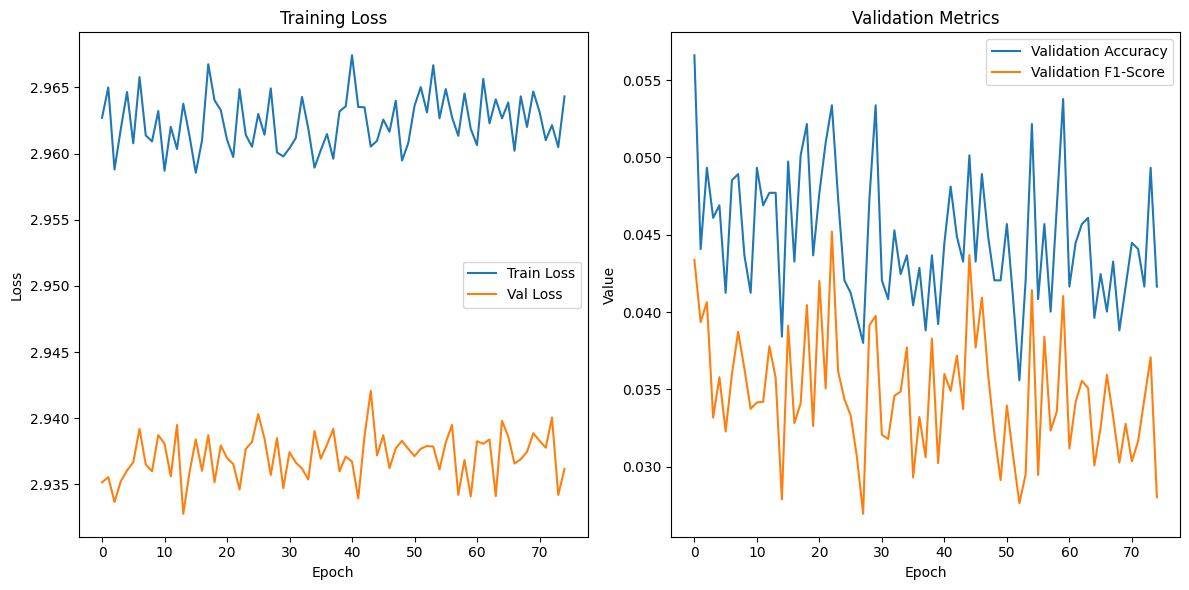

In [122]:
visualize_model_results(train_losses_pipeline4, val_losses_pipeline4, val_metrics_pipeline4, epochs=75)

In [123]:
torch.save(vgg.state_dict(), 'vgg_pipeline4_75_epochs.pth')

In [124]:
# После обучения производим предсказания и сохраняем их в требуемый формат
output_file = "test_predictions__75_pipeline4.csv"
predict_and_save(vgg, test_loader, output_file) 

100%|██████████| 166/166 [01:16<00:00,  2.17it/s]

Предсказания сохранены в файл test_predictions__75_pipeline4.csv
